# Machine Learning for Data Science 
# Time Series Classification: Wireless Sensor Data
## Rajnandini Thopte 


An interesting task in machine learning is classification of time series. In this problem, we will classify the activities of humans based on time series obtained by a Wireless Sensor Network.

## 1. Part 1: Feature Creation/Extraction

#### (a) Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\%29 .   
The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity.1 Each file containis 6 time series collected from activities of the same person, which are called avg rss12, var rss12, avg rss13, var rss13, vg rss23, and ar rss23. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.

In [57]:
# performing all imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import re
import csv
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [58]:
COLUMN_NAMES = ["time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
ORIGINAL_COLUMN_NAMES = ["# Columns: time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
STATS = ['mean', 'std_dev', 'min', '1st_quartile', 'median', '3rd_quartile', 'max']
ORDERED_Features = ['min', 'max', 'mean', 'median', 'std_dev', '1st_quartile', '3rd_quartile']
ROOT = '../data/AReM/'
sniffer = csv.Sniffer()

#### (b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [59]:
# Define a function named split_train_test that takes the 'root' directory as input.
def split_train_test(root):
    # Create empty lists to store train and test file paths.
    train = []
    test = []
    
    # Define the test datasets for each activity in a dictionary.
    test_datasets = {
        "bending1": ["dataset1.csv", "dataset2.csv"],
        "bending2": ["dataset1.csv", "dataset2.csv"],
        "cycling": ["dataset1.csv", "dataset2.csv", "dataset3.csv"],
        "lying": ["dataset1.csv", "dataset2.csv", "dataset3.csv"],
        "sitting": ["dataset1.csv", "dataset2.csv", "dataset3.csv"],
        "standing": ["dataset1.csv", "dataset2.csv", "dataset3.csv"],
        "walking": ["dataset1.csv", "dataset2.csv", "dataset3.csv"]
    }
    
    # Iterate through the folders representing activities in the 'root' directory.
    for activity_folder in os.listdir(root):
        activity_path = os.path.join(root, activity_folder)
        
        # Check if the folder is one of the activities listed in test_datasets.
        if activity_folder in test_datasets:
            # List the files in the activity folder.
            files = os.listdir(activity_path)
            
            # Iterate through the files in the activity folder.
            for file in files:
                file_path = os.path.join(activity_path, file)
                
                # Check if the file is in the test datasets for that activity.
                if file in test_datasets[activity_folder]:
                    # If it is, add the file path to the 'test' list.
                    test.append(file_path)
                else:
                    # If it's not, add the file path to the 'train' list.
                    train.append(file_path)
    
    # Return the 'train' and 'test' lists containing file paths.
    return train, test



In [60]:
ROOT = '../data/AReM/'
train, test = split_train_test(ROOT)

In [61]:
train

['../data/AReM/bending1/dataset7.csv',
 '../data/AReM/bending1/dataset6.csv',
 '../data/AReM/bending1/dataset4.csv',
 '../data/AReM/bending1/dataset5.csv',
 '../data/AReM/bending1/dataset3.csv',
 '../data/AReM/walking/dataset7.csv',
 '../data/AReM/walking/dataset6.csv',
 '../data/AReM/walking/dataset4.csv',
 '../data/AReM/walking/dataset5.csv',
 '../data/AReM/walking/dataset10.csv',
 '../data/AReM/walking/dataset11.csv',
 '../data/AReM/walking/dataset13.csv',
 '../data/AReM/walking/dataset12.csv',
 '../data/AReM/walking/dataset15.csv',
 '../data/AReM/walking/dataset14.csv',
 '../data/AReM/walking/dataset8.csv',
 '../data/AReM/walking/dataset9.csv',
 '../data/AReM/bending2/dataset6.csv',
 '../data/AReM/bending2/dataset4.csv',
 '../data/AReM/bending2/dataset5.csv',
 '../data/AReM/bending2/dataset3.csv',
 '../data/AReM/standing/dataset7.csv',
 '../data/AReM/standing/dataset6.csv',
 '../data/AReM/standing/dataset4.csv',
 '../data/AReM/standing/dataset5.csv',
 '../data/AReM/standing/dataset

In [62]:
test

['../data/AReM/bending1/dataset1.csv',
 '../data/AReM/bending1/dataset2.csv',
 '../data/AReM/walking/dataset1.csv',
 '../data/AReM/walking/dataset2.csv',
 '../data/AReM/walking/dataset3.csv',
 '../data/AReM/bending2/dataset1.csv',
 '../data/AReM/bending2/dataset2.csv',
 '../data/AReM/standing/dataset1.csv',
 '../data/AReM/standing/dataset2.csv',
 '../data/AReM/standing/dataset3.csv',
 '../data/AReM/sitting/dataset1.csv',
 '../data/AReM/sitting/dataset2.csv',
 '../data/AReM/sitting/dataset3.csv',
 '../data/AReM/lying/dataset1.csv',
 '../data/AReM/lying/dataset2.csv',
 '../data/AReM/lying/dataset3.csv',
 '../data/AReM/cycling/dataset1.csv',
 '../data/AReM/cycling/dataset2.csv',
 '../data/AReM/cycling/dataset3.csv']

#### (c) Feature Extraction
#### Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.

#### i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

In time series classification, a wide range of time-domain features can be used to describe the characteristics of time series data. These features capture various aspects of the data's behavior over time. Here are some common time-domain features that are often used:  


1] Mean: The average value of the data points in the time series.  


2] Median: The middle value in the sorted order of the data points.  


3] Minimum: The smallest value in the time series.  


4] Maximum: The largest value in the time series.  


5] Variance: A measure of the spread or dispersion of data points.  


6] Standard Deviation: The square root of the variance, providing another measure of data spread.  


7] Skewness: A measure of the asymmetry of the data distribution.  


8] Kurtosis: A measure of the "tailedness" of the data distribution.  


9] Range: The difference between the maximum and minimum values.  


10] Quantiles: Values that divide the data into equal-sized subsets (e.g., quartiles, percentiles).  


11] Interquartile Range (IQR): The range between the first quartile (25th percentile) and the third quartile (75th percentile).  


12] Mean Absolute Deviation (MAD): The average absolute difference between each data point and the mean. 


13] Root Mean Square (RMS): The square root of the mean of the squared values.  


14] Coefficient of Variation (CV): The ratio of the standard deviation to the mean.  


15] Autocorrelation: Measures the correlation between a time series and a lagged version of itself.   


16] Entropy: A measure of the randomness or unpredictability of the time series.  


17] Zero Crossing Rate: The rate at which the time series crosses the zero axis.  


18] Energy: The sum of the squared values in the time series.  


19] Hurst Exponent: A measure of long-range dependence in the time series.  


20] Waveform Length: The sum of the absolute differences between consecutive data points.  



These features provide valuable information about the statistical properties, shape, and dynamics of time series data. Depending on the specific problem and dataset, different combinations of these features may be used for feature extraction and subsequent time series classification. Additionally, domain-specific features and transformations may be applied for more specialized tasks.  

#### ii. Extract the time-domain features minimum, maximum, mean, median, stan- dard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.2

In [63]:
# finding the separator in the CSV file
def find_common_separator(file):
    f = open(file)
    return sniffer.sniff(f.read()).delimiter

# parses the file and evaluates the label for all given instances
def extract_labelname(file):
    # Extract the label from the file's parent directory using os.path.basename()
    label = os.path.basename(os.path.dirname(file))
    return label

# fetch all columns for the resultant dataset 
def get_columns(segs=1):
    return [f'{stat}{i}' for i in range(1, 6 * segs + 1) for stat in STATS]
    



In [64]:
# utility method to load the data after parsing the file
def process_test_train_data(files, feature, cols, segs=1, standard=False):
    import csv
    
    instances  = []
    labels = []
    
    for f in files:
        labels.append(extract_labelname(f))
        separator = find_common_separator(f)
        
        if separator == ",":
            fc = pd.read_csv(f, skiprows=5, header=None, on_bad_lines='skip')
        elif separator == "\\s+":
            fc = pd.read_csv(f, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')
        else:
            fc = pd.read_csv(f, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')
            
        fc.columns = ORIGINAL_COLUMN_NAMES
        
        # breaking time series into equal lengths
        seg_length = int(fc.shape[0] / segs)
        description = []
        for i in range(segs):
            start1 = i * seg_length
            end1 = min((i + 1) * seg_length, fc.shape[0])
            cur_seg = fc[start1 : end1]
            time_col = "# Columns: time"
            cur_describe = cur_seg.describe().drop('count').drop(columns=time_col).T
            description.append(cur_describe.values.flatten())

        instances.append(np.concatenate(description))
            
    # reordering
    feature_df = pd.DataFrame(instances)
    feature_df.columns = get_columns(segs)
    feature_df = feature_df.loc[:, feature]
    
    # label addition
    feature_df['label'] = pd.Series(labels)
    
    return feature_df

def get_actual_ordered_cols():
    return [f'{stat}{i}' for i in range(1, 7) for stat in ORDERED_Features]

feature = get_actual_ordered_cols()

In [65]:
train_data = process_test_train_data(train, feature, ORIGINAL_COLUMN_NAMES)
train_data

min1   max1      mean1  median1  std_dev1  1st_quartile1  3rd_quartile1  \
0   36.25  48.00  43.969125    44.50  1.618364         43.310          44.67   
1   37.00  48.00  43.454958    43.25  1.386098         42.500          45.00   
2   33.00  47.75  42.179812    43.50  3.670666         39.150          45.00   
3   33.00  45.75  41.678063    41.75  2.243490         41.330          42.75   
4   35.00  47.40  43.954500    44.33  1.558835         43.000          45.00   
..    ...    ...        ...      ...       ...            ...            ...   
64  18.50  44.25  35.752354    36.00  4.614802         33.000          39.33   
65  24.25  45.00  37.177042    36.25  3.581301         34.500          40.25   
66  23.33  43.50  36.248768    36.75  3.824632         33.415          39.25   
67  26.25  44.25  36.957458    36.29  3.434863         34.500          40.25   
68  27.75  44.67  37.142359    36.33  3.762442         34.000          40.50   

    min2   max2     mean2  ...  1st_quartile5  3rd_quartile5  min6   max6  \
0    0.0   1.50  0.413125  ...        20.5000        23.7500   0.0   2.96   
1    0.0   1.58  0.378083  ...        22.2500        24.0000   0.0   5.26   
2    0.0   3.00  0.696042  ...        30.4575        36.3300   0.0   2.18   
3    0.0   2.83  0.535979  ...        28.4575        31.2500   0.0   1.79   
4    0.0   1.70  0.426250  ...        35.3625        36.5000   0.0   1.79   
..   ...    ...       ...  ...            ...            ...   ...    ...   
64   0.0  12.60  3.328104  ...        14.0000        18.0625   0.0   9.39   
65   0.0   8.58  2.374208  ...        17.9500        21.7500   0.0   9.34   
66   0.0   9.71  2.737307  ...        15.7500        21.0000   0.0  11.15   
67   0.0   8.64  2.420083  ...        14.0000        18.2500   0.0   8.34   
68   0.0  10.76  2.422150  ...        15.0000        18.7500   0.0   8.75   

       mean6  median6  std_dev6  1st_quartile6  3rd_quartile6     label  
0   0.555312    0.490  0.487826         0.0000          0.830  bending1  
1   0.679646    0.500  0.622534         0.4300          0.870  bending1  
2   0.613521    0.500  0.524317         0.0000          1.000  bending1  
3   0.383292    0.430  0.389164         0.0000          0.500  bending1  
4   0.493292    0.430  0.513506         0.0000          0.940  bending1  
..       ...      ...       ...            ...            ...       ...  
64  3.069667    2.770  1.748326         1.7975          4.060   cycling  
65  2.921729    2.500  1.852600         1.5000          3.900   cycling  
66  3.532463    3.110  1.965267         2.1700          4.625   cycling  
67  2.934625    2.525  1.631380         1.6600          4.030   cycling  
68  2.825720    2.590  1.637312         1.5900          3.740   cycling  

[69 rows x 43 columns]

In [66]:
test_data = process_test_train_data(test, feature, ORIGINAL_COLUMN_NAMES)
test_data

min1   max1      mean1  median1  std_dev1  1st_quartile1  3rd_quartile1  \
0   37.25  45.00  40.624792   40.500  1.476967        39.2500        42.0000   
1   38.00  45.67  42.812812   42.500  1.435550        42.0000        43.6700   
2   19.33  43.50  34.227771   35.500  4.889576        30.5000        37.7500   
3   12.50  45.00  33.509729   34.125  4.850923        30.5000        36.7500   
4   15.00  46.75  34.660583   35.000  5.315110        31.0000        38.2500   
5   12.75  51.00  24.562958   24.250  3.737514        23.1875        26.5000   
6    0.00  42.75  27.464604   28.000  3.583582        25.5000        30.0000   
7   33.33  48.00  44.334729   45.000  2.476940        42.2500        46.5000   
8   35.50  46.25  43.174938   43.670  1.989052        42.5000        44.5000   
9   32.75  47.00  42.760562   44.500  3.398919        41.3300        45.3725   
10  33.25  48.00  42.363563   43.000  2.068247        42.0000        43.5000   
11  37.00  50.75  45.917667   45.635  1.089027        45.0000        46.5000   
12  44.50  46.75  45.239667   45.000  0.429915        45.0000        45.3300   
13  23.50  30.00  27.716375   27.500  1.442253        27.0000        29.0000   
14  24.75  48.33  44.182937   48.000  7.495615        48.0000        48.0000   
15  48.00  48.25  48.004167   48.000  0.032038        48.0000        48.0000   
16  24.25  45.00  37.177042   36.250  3.581301        34.5000        40.2500   
17  28.75  44.75  37.561187   36.875  3.226507        35.2500        40.2500   
18  22.00  44.67  37.058708   36.000  3.710180        34.5000        40.0625   

    min2   max2     mean2  ...  1st_quartile5  3rd_quartile5  min6  max6  \
0    0.0   1.30  0.358604  ...        33.0000        36.0000   0.0  1.92   
1    0.0   1.22  0.372437  ...        32.0000        34.5000   0.0  3.11   
2    0.0  14.50  3.995729  ...        14.7500        18.6700   0.0  9.74   
3    0.0  13.05  4.450771  ...        14.6275        18.7500   0.0  8.96   
4    0.0  13.44  4.200896  ...        14.2500        18.5000   0.0  8.99   
5    0.0   6.87  0.590833  ...        20.5000        27.0000   0.0  4.97   
6    0.0   7.76  0.449708  ...        15.0000        20.7500   0.0  6.76   
7    0.0   3.90  0.432958  ...         9.3300        17.7500   0.0  5.02   
8    0.0   2.12  0.506583  ...        12.7500        16.5000   0.0  5.72   
9    0.0   3.34  0.486167  ...        13.0000        18.5650   0.0  5.73   
10   0.0   4.44  0.492563  ...        10.1875        17.6900   0.0  6.02   
11   0.0   4.87  0.324542  ...        16.5000        21.0000   0.0  7.22   
12   0.0   1.00  0.172958  ...        17.6275        21.0000   0.0  8.20   
13   0.0   1.79  0.363687  ...         5.5000        10.7500   0.0  4.50   
14   0.0   3.11  0.101875  ...         2.0000         5.5425   0.0  3.91   
15   0.0   0.43  0.007167  ...         4.6700        10.0000   0.0  2.50   
16   0.0   8.58  2.374208  ...        17.9500        21.7500   0.0  9.34   
17   0.0   9.91  2.080687  ...        18.0000        21.5000   0.0  9.62   
18   0.0  14.17  2.438146  ...        16.0000        21.0000   0.0  8.55   

       mean6  median6  std_dev6  1st_quartile6  3rd_quartile6     label  
0   0.570583    0.430  0.582915         0.0000          1.300  bending1  
1   0.571083    0.430  0.601010         0.0000          1.300  bending1  
2   3.394125    3.100  1.792090         2.1050          4.425   walking  
3   3.378479    3.085  1.787360         2.0600          4.440   walking  
4   3.244396    3.000  1.630983         2.1200          4.240   walking  
5   0.700188    0.500  0.693720         0.4300          0.870  bending2  
6   1.122125    0.830  1.012342         0.4700          1.300  bending2  
7   0.933000    0.830  0.673609         0.4700          1.250  standing  
8   0.911979    0.830  0.666161         0.4700          1.220  standing  
9   0.842271    0.710  0.722165         0.4300          1.090  standing  
10  1.034021    0.830  0.985627         0.4700          1.250   sitti

#### iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [67]:
print ("Standard Deviation of each of the time-domain features for Training Data\n ")
train_data.describe().loc['std']


Standard Deviation of each of the time-domain features for Training Data
 


min1             8.794295
max1             4.429182
mean1            4.917692
median1          4.956111
std_dev1         1.758670
1st_quartile1    5.731647
3rd_quartile1    4.783645
min2             0.000000
max2             5.147841
mean2            1.600701
median2          1.436960
std_dev2         0.902808
1st_quartile2    0.952201
3rd_quartile2    2.158416
min3             3.053869
max3             4.759853
mean3            3.863097
median3          3.845730
std_dev3         0.995959
1st_quartile3    4.145255
3rd_quartile3    3.946023
min4             0.000000
max4             2.302408
mean4            1.179861
median4          1.150092
std_dev4         0.473576
1st_quartile4    0.842501
3rd_quartile4    1.566564
min5             5.368786
max5             5.449726
mean5            5.120426
median5          5.267414
std_dev5         1.057998
1st_quartile5    5.543882
3rd_quartile5    4.957231
min6             0.051766
max6             2.540166
mean6            1.171401
median6     

In [68]:
print ("\nStandard Deviation of each of the time-domain features for Testing Data\n ")
test_data.describe().loc['std']



Standard Deviation of each of the time-domain features for Testing Data
 


min1             12.136206
max1              4.379342
mean1             6.790086
median1           7.088085
std_dev1          1.869285
1st_quartile1     7.673052
3rd_quartile1     6.385720
min2              0.000000
max2              4.870395
mean2             1.500529
median2           1.345903
std_dev2          0.832472
1st_quartile2     0.941307
3rd_quartile2     2.028482
min3              2.644618
max3              5.393220
mean3             4.588252
median3           4.753522
std_dev3          0.760779
1st_quartile3     4.554121
3rd_quartile3     5.014339
min4              0.000000
max4              1.733937
mean4             1.146338
median4           1.161705
std_dev4          0.409008
1st_quartile4     0.867088
3rd_quartile4     1.541943
min5              8.252947
max5              6.782153
mean5             7.366781
median5           7.438749
std_dev5          0.919274
1st_quartile5     7.823870
3rd_quartile5     7.259433
min6              0.000000
max6              2.505306
m

In [69]:
# building 90% confidence interval
# Extract the features (excluding the 'label' column) from the training data
data = train_data.iloc[:, :-1]

# Get the names of the features
feature_names = data.columns

# Initialize an empty list to store the results
results = []

# Define the number of bootstrap samples
n_bootstrap_samples = 1000

# Perform bootstrap resampling and calculate standard deviations
for sample in range(n_bootstrap_samples):
    # Resample the data with replacement
    resampled_data = resample(data)
    
    # Calculate the standard deviation for each column (feature)
    std_devs = resampled_data.apply(lambda col: np.std(col))
    
    # Append the calculated standard deviations to the results list
    results.append(std_devs)

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Calculate the 90% confidence interval for each feature
confidence_intervals = results_df.apply(lambda col: (np.percentile(col, 5), np.percentile(col, 95)), axis=0)

# Round the values in the confidence interval DataFrame to 3 decimal places
confidence_intervals = confidence_intervals.round(3)

# Transpose the confidence interval DataFrame for a clearer view
confidence_intervals = confidence_intervals.T


confidence_intervals.rename(columns={0: 'Lower Bound', 1: 'Upper Bound'}, inplace=True)

# Add a 'Standard Deviation' column
confidence_intervals['Standard Deviation'] = data.apply(lambda col: np.std(col))

# Reset the index to have 'min1', 'max1', etc. as index values
confidence_intervals.index = feature_names

# Create a Styler object for alternating row colors
display_table = confidence_intervals.style.apply(lambda x: ['background-color: #f2f2f2' if i % 2 == 0 else '' for i in range(len(x))])

# Display the styled DataFrame

display_table

#### iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

Here, we have confidence intervals for various time-domain features, we can consider factors such as interpretability, relevance to human activities, and the spread of the confidence intervals. Based on these considerations, here are three important features:  


#### 1] Mean :  
The mean represents the average value of the time series data.
It is a fundamental statistical measure and can provide insights into the central tendency of the sensor data.
Mean values are interpretable and can be used to understand the typical behavior of the measured quantities during human activities.  
Analysis: Mean values can be used to identify the baseline behavior of sensor data. It's useful for detecting changes or anomalies in the data.  

#### 2] Standard Deviation :  
Standard deviation measures the spread or variability of the data.
A higher standard deviation suggests greater variability in the sensor readings, which could be relevant for detecting variations in human activities.
It can be an indicator of the stability or consistency of the measured signals during different activities.  
Analysis: A higher standard deviation may indicate more variability or noise in the data. It can be valuable for identifying fluctuations or irregularities.  

#### 3] Max :  
The maximum value represents the highest point reached in the time series data.
Maximum values can be useful for identifying peak activities or extreme events during human activities.
They may capture the moments when certain sensor readings reach their highest levels, which could be indicative of specific activities.    
Analysis: Monitoring maximum values can help identify spikes or extreme values in the data, which may be relevant for detecting unusual events.  


These features are chosen based on their interpretability and relevance to understanding human activities. The mean provides information about the central tendency, the standard deviation indicates variability, and the maximum values highlight extreme points in the data. 

#### 2. ISLR 3.7.4

__I collect a set of data (n = 100 observations) containing a single
predictor and a quantitative response. I then fit a linear regression
model to the data, as well as a separate cubic regression, i.e. Y =
β0 + β1X + β2X2 + β3X3 + ϵ.__

__(a) Suppose that the true relationship between X and Y is linear,
i.e. Y = β0 + β1X + ϵ. Consider the training residual sum of
squares (RSS) for the linear regression, and also the training
RSS for the cubic regression. Would we expect one to be lower
than the other, would we expect them to be the same, or is there
not enough information to tell? Justify your answer.__

__(b) Answer (a) using test rather than training RSS.__

__(c) Suppose that the true relationship between X and Y is not linear,
but we don’t know how far it is from linear. Consider the training
RSS for the linear regression, and also the training RSS for the
cubic regression. Would we expect one to be lower than the
other, would we expect them to be the same, or is there not
enough information to tell? Justify your answer.__  

__(d) Answer (c) using test rather than training RSS.__

#### ANSWERS

#### (a) Training RSS for Linear vs. Cubic Regression when the True Relationship is Linear:  


When the true relationship between X and Y is linear, i.e., Y = β0 + β1X + ϵ, and you fit a linear regression model to the data, the linear model should capture this true linear relationship. On the other hand, when you fit a cubic regression model (Y = β0 + β1X + β2X^2 + β3X^3 + ϵ), it is a more flexible model capable of fitting more complex relationships.  


In this scenario, for the training dataset, the cubic regression model is overly flexible and can fit the data perfectly, resulting in a lower training RSS compared to the linear model. The cubic regression model can fit not only the linear relationship but also additional variations, which can lead to overfitting.  


So, we can expect the training RSS for the cubic regression to be lower than that of the linear regression.   

 
#### (b) Test RSS for Linear vs. Cubic Regression when the True Relationship is Linear:  


When considering the test RSS, the situation may change. The cubic regression model, being more flexible, can fit noise in the training data, which may not generalize well to new, unseen data. In contrast, the linear regression model, being simpler, may generalize better to new data that follows a linear relationship.


In practice, it's possible that the test RSS for the linear regression model could be lower or at least competitive with that of the cubic regression model, especially if the true relationship is indeed linear. The cubic regression model may suffer from overfitting when applied to the test data.  


#### (c) Training RSS for Linear vs. Cubic Regression when the True Relationship is Not Linear:  


When the true relationship between X and Y is not linear, and you fit both linear and cubic regression models to the data, it's important to consider the bias-variance trade-off. The linear regression model is less flexible and assumes a linear relationship, which may result in high bias (underfitting) when the true relationship is nonlinear.  


On the other hand, the cubic regression model is more flexible and can capture nonlinear relationships. However, this flexibility may lead to overfitting if the true relationship is not too far from linear.  


In this scenario, the training RSS for the cubic regression may be lower because it has the capacity to fit more complex, nonlinear patterns in the data.   


#### (d) Test RSS for Linear vs. Cubic Regression when the True Relationship is Not Linear:  


Similar to the training RSS, the test RSS for the cubic regression may be lower than that of the linear regression if the cubic regression model captures the nonlinear aspects of the true relationship in the test data. However, this depends on how well the cubic model generalizes to new data.  


If the cubic regression model overfits the training data by capturing noise, it may perform worse on the test data compared to the linear model. Therefore, the relative performance of the two models on the test data would depend on factors such as the complexity of the true relationship and the amount of noise in the data.  


In summary, the expected performance of the linear and cubic regression models in terms of RSS depends on the true relationship between X and Y, the flexibility of the models, and the presence of noise in the data. It's essential to consider both training and test RSS to assess the models' ability to fit the data and generalize to new observations.  


## Part 2: Binary and Multiclass Classification


#### (a) Binary Classification Using Logistic Regression3  
#### i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).4

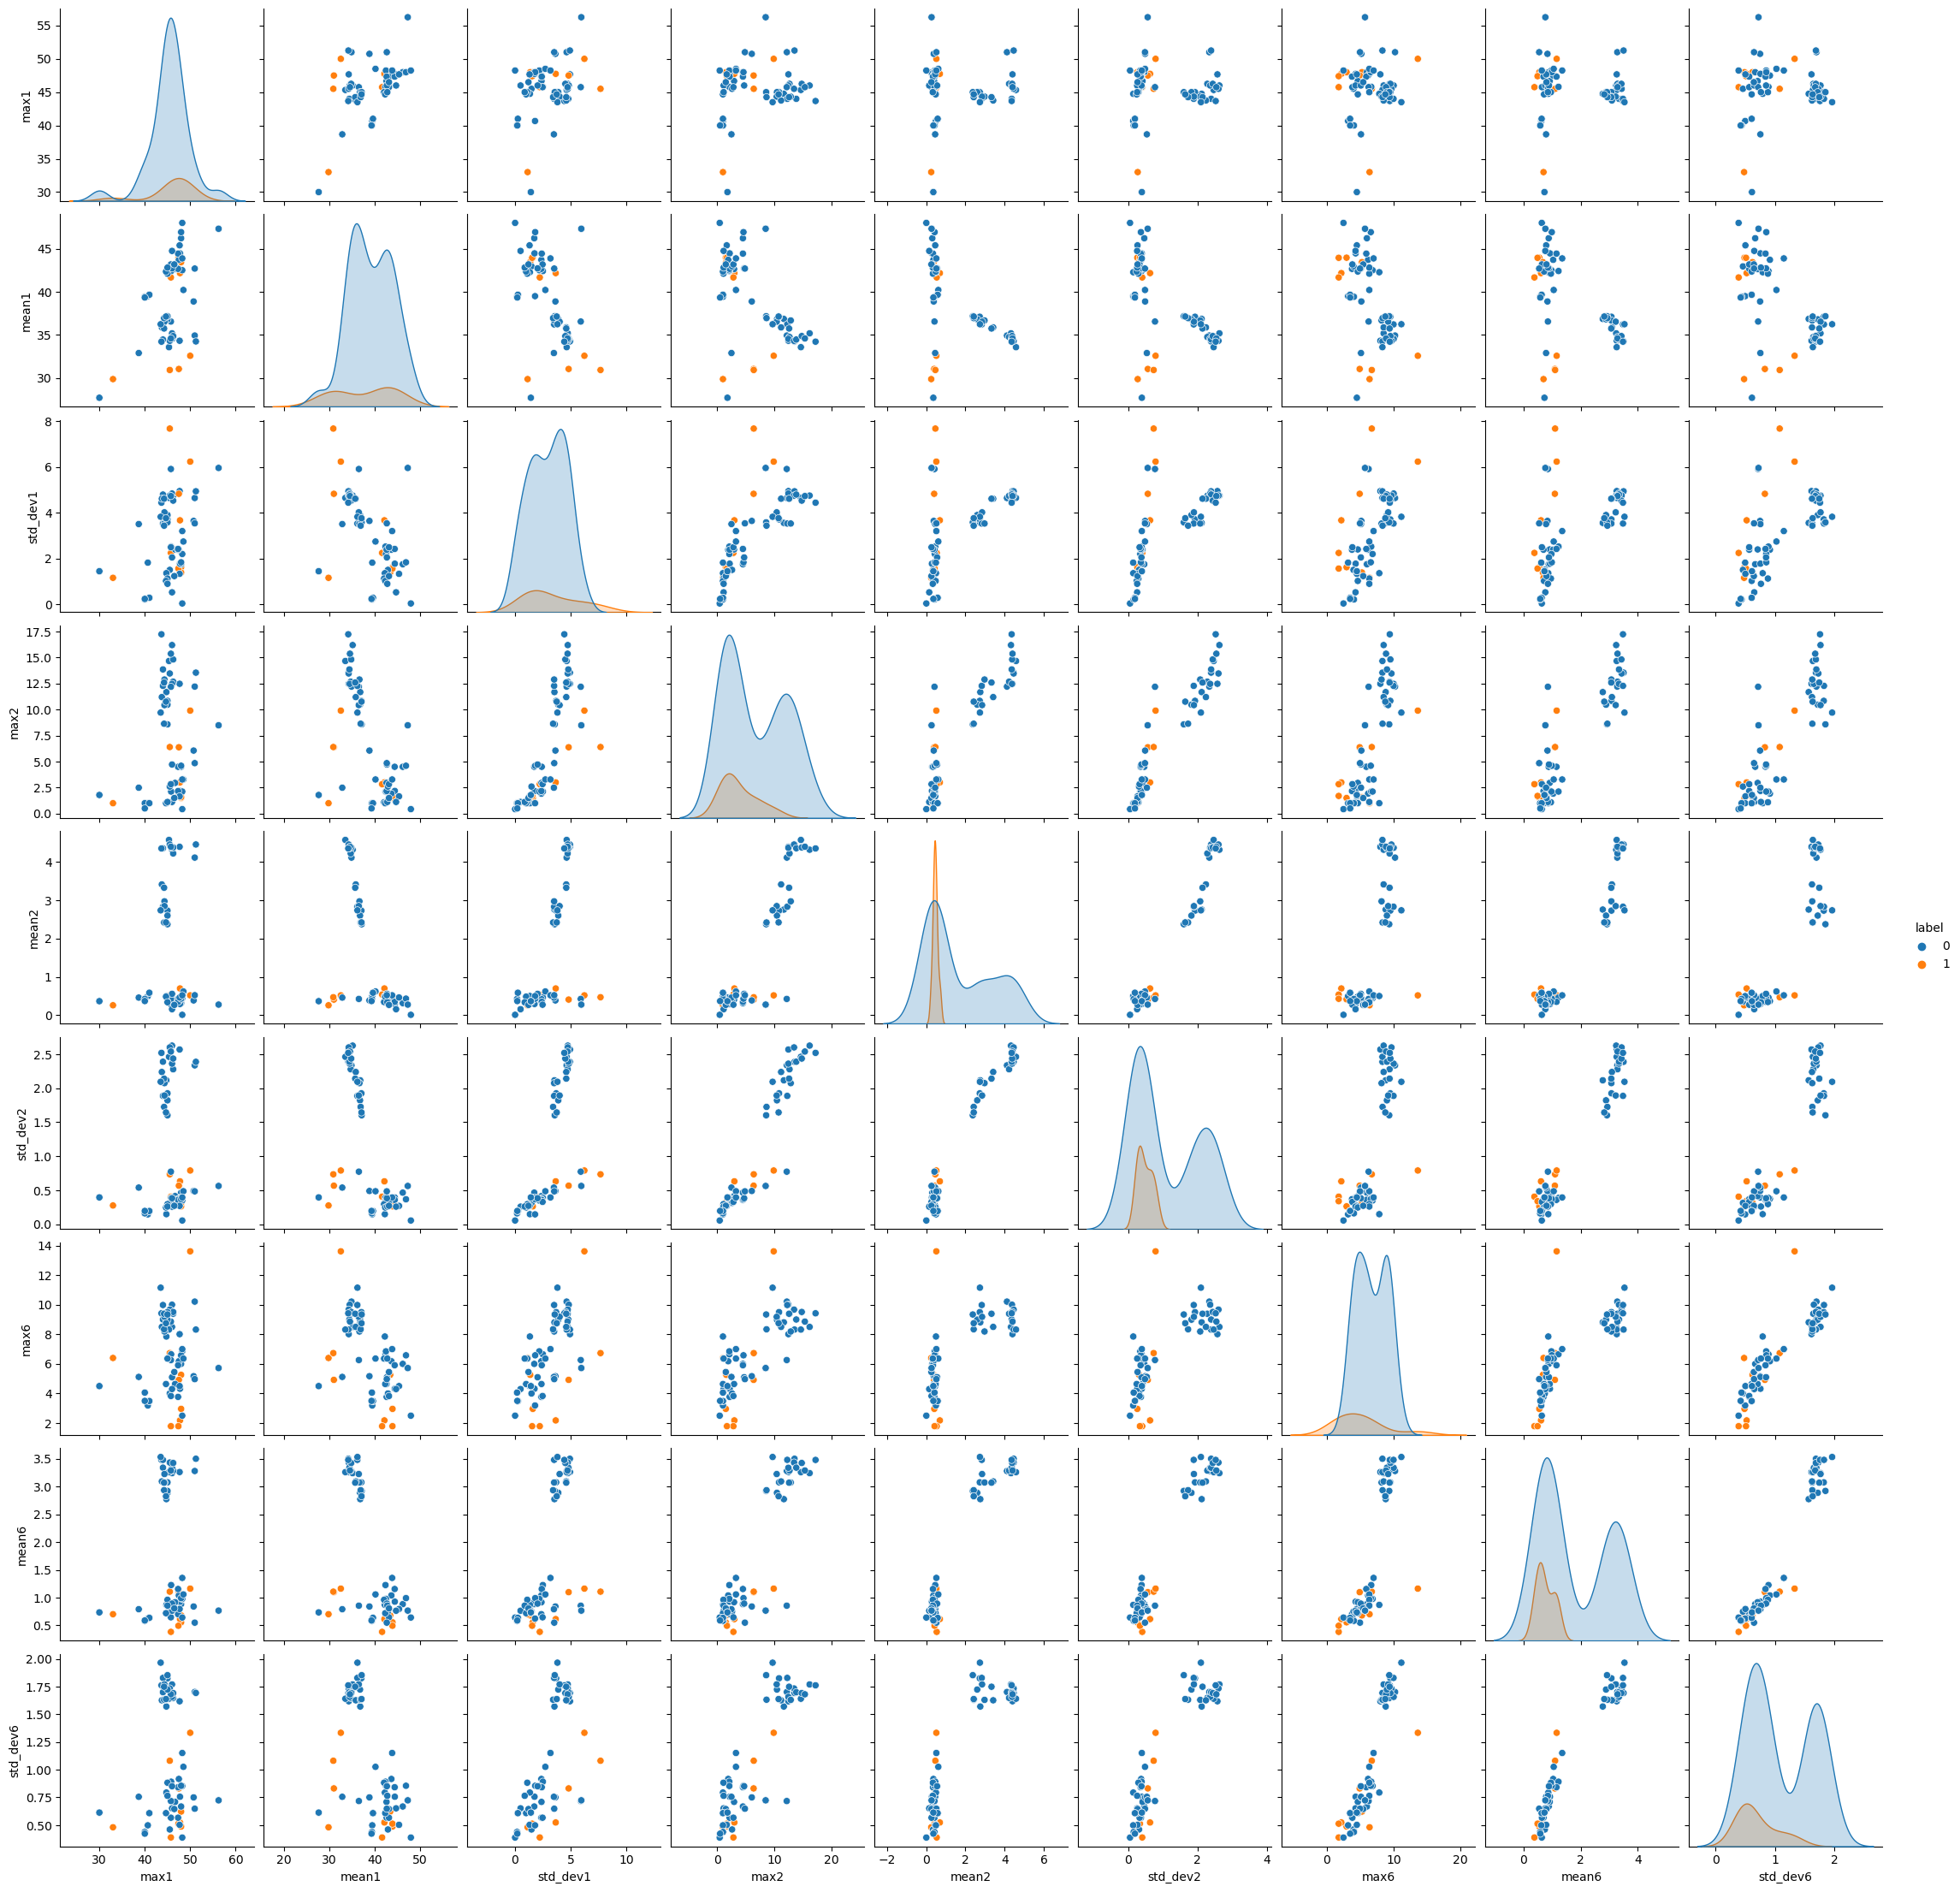

In [70]:
# Define a function to generate column names based on indexes and properties
def generate_col_name(indexes, props):
    # Use list comprehension to generate column names
    return [prop + str(index) for index in indexes for prop in props]

# Define a function to label the 'label' column as 1 for 'bending1' and 'bending2', and 0 for others
def label_col_name(df, cols):
    # Use the apply method and a lambda function to label the 'label' column
    df['label'] = df['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)
    # Return the columns including the 'label' column
    return cols + ['label']

def plot_scatter_plot(df):
    sns.pairplot(df, hue='label')  # Use 'label' for hue
    plt.show()

# Generate relevant column names based on indexes and properties
relevant_columns = generate_col_name([1, 2, 6], ['max', 'mean', 'std_dev'])
# Label the 'label' column in the training data
BCLR_columns_labelled = label_col_name(train_data, relevant_columns)

# Select the relevant columns from the training data
BCLR_df = train_data[BCLR_columns_labelled]

plot_scatter_plot(BCLR_df)


#### ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 4(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 4(a)i?

In [71]:
# Initialize an empty list to store feature column names
feature_col_name = []

# Generate feature column names based on indexes and ordered statistics
for i in range(1, 13):
    for stat in ORDERED_Features:
        col_name = f'{stat}{i}'
        feature_col_name.append(col_name)



In [72]:
# Process the training data with two segments and convert labels to binary
train_data_2 = process_test_train_data(train, feature_col_name, ORIGINAL_COLUMN_NAMES, segs=2)

# Process the test data with two segments and convert labels to binary
test_data_2 = process_test_train_data(test, feature_col_name, ORIGINAL_COLUMN_NAMES, segs=2)


In [73]:
# Define a utility method to convert text labels into binary labels (0 and 1)
def get_binary_labelled_dataframe(df):
    # Extract the 'label' column
    temp = df['label']
    
    # Set 'label' to 1 for 'bending1' and 'bending2', and 0 for other values
    df.loc[temp.isin(['bending1', 'bending2']), 'label'] = 1
    df.loc[temp != 1, 'label'] = 0
    
    # Return the modified DataFrame
    return df


In [74]:
print("Train dataframe\n")
train_df_2 = get_binary_labelled_dataframe(pd.DataFrame(train_data_2))
train_df_2


Train dataframe



min1   max1      mean1  median1  std_dev1  1st_quartile1  3rd_quartile1  \
0   36.67  45.00  43.486208    43.71  1.281976        42.3300          44.50   
1   39.00  48.00  44.117042    45.00  1.359836        43.5000          45.00   
2   33.75  47.75  43.278875    45.00  3.473355        42.0000          45.25   
3   33.00  45.75  41.621208    42.33  3.118644        39.6525          44.25   
4   36.50  46.50  44.057167    44.50  1.556971        43.2500          45.00   
..    ...    ...        ...      ...       ...            ...            ...   
64  20.00  44.25  35.692167    35.50  4.643595        33.0000          39.25   
65  24.25  45.00  36.954208    36.00  3.772836        34.2500          40.25   
66  27.00  42.67  36.337908    36.75  3.655379        33.6700          39.00   
67  26.25  43.40  36.865417    36.25  3.462793        34.3100          40.00   
68  27.75  44.00  37.132636    36.67  3.808255        34.0000          40.33   

    min2   max2     mean2  ...  1st_quartile11  3rd_quartile11  min12  max12  \
0    0.0   1.30  0.378667  ...          21.000         23.5000    0.0   2.96   
1    0.0   1.30  0.250042  ...          22.500         23.7500    0.0   4.06   
2    0.0   3.00  0.673292  ...          28.750         33.7500    0.0   2.18   
3    0.0   2.83  0.623083  ...          28.310         30.5625    0.0   1.50   
4    0.0   1.50  0.381042  ...          33.000         36.2500    0.0   1.50   
..   ...    ...       ...  ...             ...             ...    ...    ...   
64   0.0  11.39  3.324208  ...          14.000         18.2500    0.0   8.81   
65   0.0   8.18  2.392667  ...          18.000         21.6700    0.0   9.34   
66   0.0   9.71  2.698494  ...          16.125         21.0000    0.0  11.15   
67   0.0   7.46  2.387250  ...          14.330         18.0000    0.0   8.34   
68   0.0  10.76  2.388870  ...          15.000         18.7500    0.0   7.93   

      mean12  median12  std_dev12  1st_quartile12  3rd_quartile12  label  
0   0.585750      0.50   0.487918          0.4225          0.8300      1  
1   0.543875      0.50   0.473445          0.4300          0.7100      1  
2   0.586083      0.47   0.491873          0.0000          0.8700      1  
3   0.347500      0.43   0.363144          0.0000          0.5000      1  
4   0.388333      0.00   0.478528          0.0000          0.7100      1  
..       ...       ...        ...             ...             ...    ...  
64  2.966917      2.59   1.712062          1.8525          3.7400      0  
65  2.838083      2.45   1.890755          1.3825          3.8325      0  
66  3.530669      3.08   1.998170          2.1700          4.5150      0  
67  2.904458      2.57   1.609793          1.6900          3.7700      0  
68  2.727866      2.55   1.588045          1.5000          3.7000      0  

[69 rows x 85 columns]

In [75]:
print("Test dataframe\n")
test_df_2 = get_binary_labelled_dataframe(pd.DataFrame(test_data_2))
test_df_2

Test dataframe



min1   max1      mean1  median1  std_dev1  1st_quartile1  3rd_quartile1  \
0   38.00  42.33  40.946958   41.250  1.102963        40.3100        42.0000   
1   41.75  44.25  42.643292   42.500  0.641849        42.0000        43.3300   
2   22.33  42.50  34.334833   35.750  4.772089        30.4750        37.7500   
3   18.67  45.00  33.762958   34.500  5.001292        30.7500        37.3125   
4   15.00  45.33  33.591625   34.250  5.121057        30.0000        37.0000   
5   12.75  51.00  24.675375   24.330  4.856867        22.2500        26.7500   
6   26.50  31.33  29.071583   29.500  1.133954        28.2500        30.0000   
7   38.50  48.00  46.127875   46.500  1.151699        45.5000        46.7500   
8   35.50  45.00  43.043292   43.500  1.874343        42.5000        44.5000   
9   37.00  46.50  44.447083   45.000  1.667042        44.1875        45.5000   
10  40.50  44.00  42.681292   42.585  0.803629        42.0000        43.5000   
11  37.00  50.75  45.811458   45.000  1.421195        45.0000        46.5000   
12  45.00  46.75  45.409875   45.250  0.529789        45.0000        45.7500   
13  23.50  29.75  27.368417   27.000  1.295725        27.0000        28.7500   
14  24.75  48.25  40.361042   48.000  9.125029        29.5000        48.0000   
15  48.00  48.25  48.001042   48.000  0.016137        48.0000        48.0000   
16  24.25  45.00  36.954208   36.000  3.772836        34.2500        40.2500   
17  29.25  44.75  37.592250   37.000  3.127179        35.2500        39.7500   
18  28.00  44.67  37.740667   36.710  3.536378        35.2500        40.7500   

    min2   max2     mean2  ...  1st_quartile11  3rd_quartile11  min12  max12  \
0   0.00   1.22  0.375667  ...         31.3100         36.5000    0.0   1.92   
1   0.00   0.94  0.355000  ...         30.0000         33.7500    0.0   3.11   
2   0.00  12.19  3.974958  ...         14.7500         18.5000    0.0   8.86   
3   0.43  13.05  4.400833  ...         14.7300         18.8125    0.0   8.96   
4   0.00  12.53  4.573042  ...         14.1875         18.5000    0.0   8.26   
5   0.00   6.87  0.774500  ...         19.4575         21.7500    0.0   4.97   
6   0.00   1.25  0.231208  ...         12.3300         20.7625    0.0   6.76   
7   0.00   1.79  0.424542  ...          7.0000         12.0000    0.0   3.77   
8   0.00   2.12  0.500667  ...         13.6700         17.0000    0.0   4.64   
9   0.00   1.73  0.410458  ...         11.7500         18.8125    0.0   5.73   
10  0.00   1.12  0.365875  ...         14.5000         18.7500    0.0   5.85   
11  0.00   4.87  0.204167  ...         17.0000         20.7500    0.0   7.22   
12  0.00   1.00  0.260750  ...         17.7500         21.0000    0.0   3.49   
13  0.00   1.79  0.308042  ...          3.3300         10.0000    0.0   3.30   
14  0.00   3.11  0.194583  ...          1.5000          2.5000    0.0   3.77   
15  0.00   0.43  0.001792  ...          9.5000         10.7500    0.0   1.30   
16  0.00   8.18  2.392667  ...         18.0000         21.6700    0.0   9.34   
17  0.00   8.95  2.111625  ...         18.2500         21.5425    0.0   9.62   
18  0.00  12.99  2.147167  ...         14.1875         19.3125    0.0   8.55   

      mean12  median12  std_dev12  1st_quartile12  3rd_quartile12  label  
0   0.552167     0.430   0.510494          0.0000          0.9400      1  
1   0.533583     0.430   0.575061          0.0000          0.8700      1  
2   3.400750     3.080   1.804246          2.0600          4.5000      0  
3   3.378250     3.110   1.803453          2.0575          4.4550      0  
4   3.206833     2.980   1.710663          1.9800          4.2450      0  
5   0.936917     0.810   0.818833          0.4700          1.0975      1  
6   1.473250     1.220   1.238675          0.5000          1.9525      1  
7   0.870042     0.820   0.678663          0.4600          1.1450      0  
8   0.874750     0.830   0.635470          0.4700          1.1700      0  
9   0.906500     0.830   0.741206          0.4300    

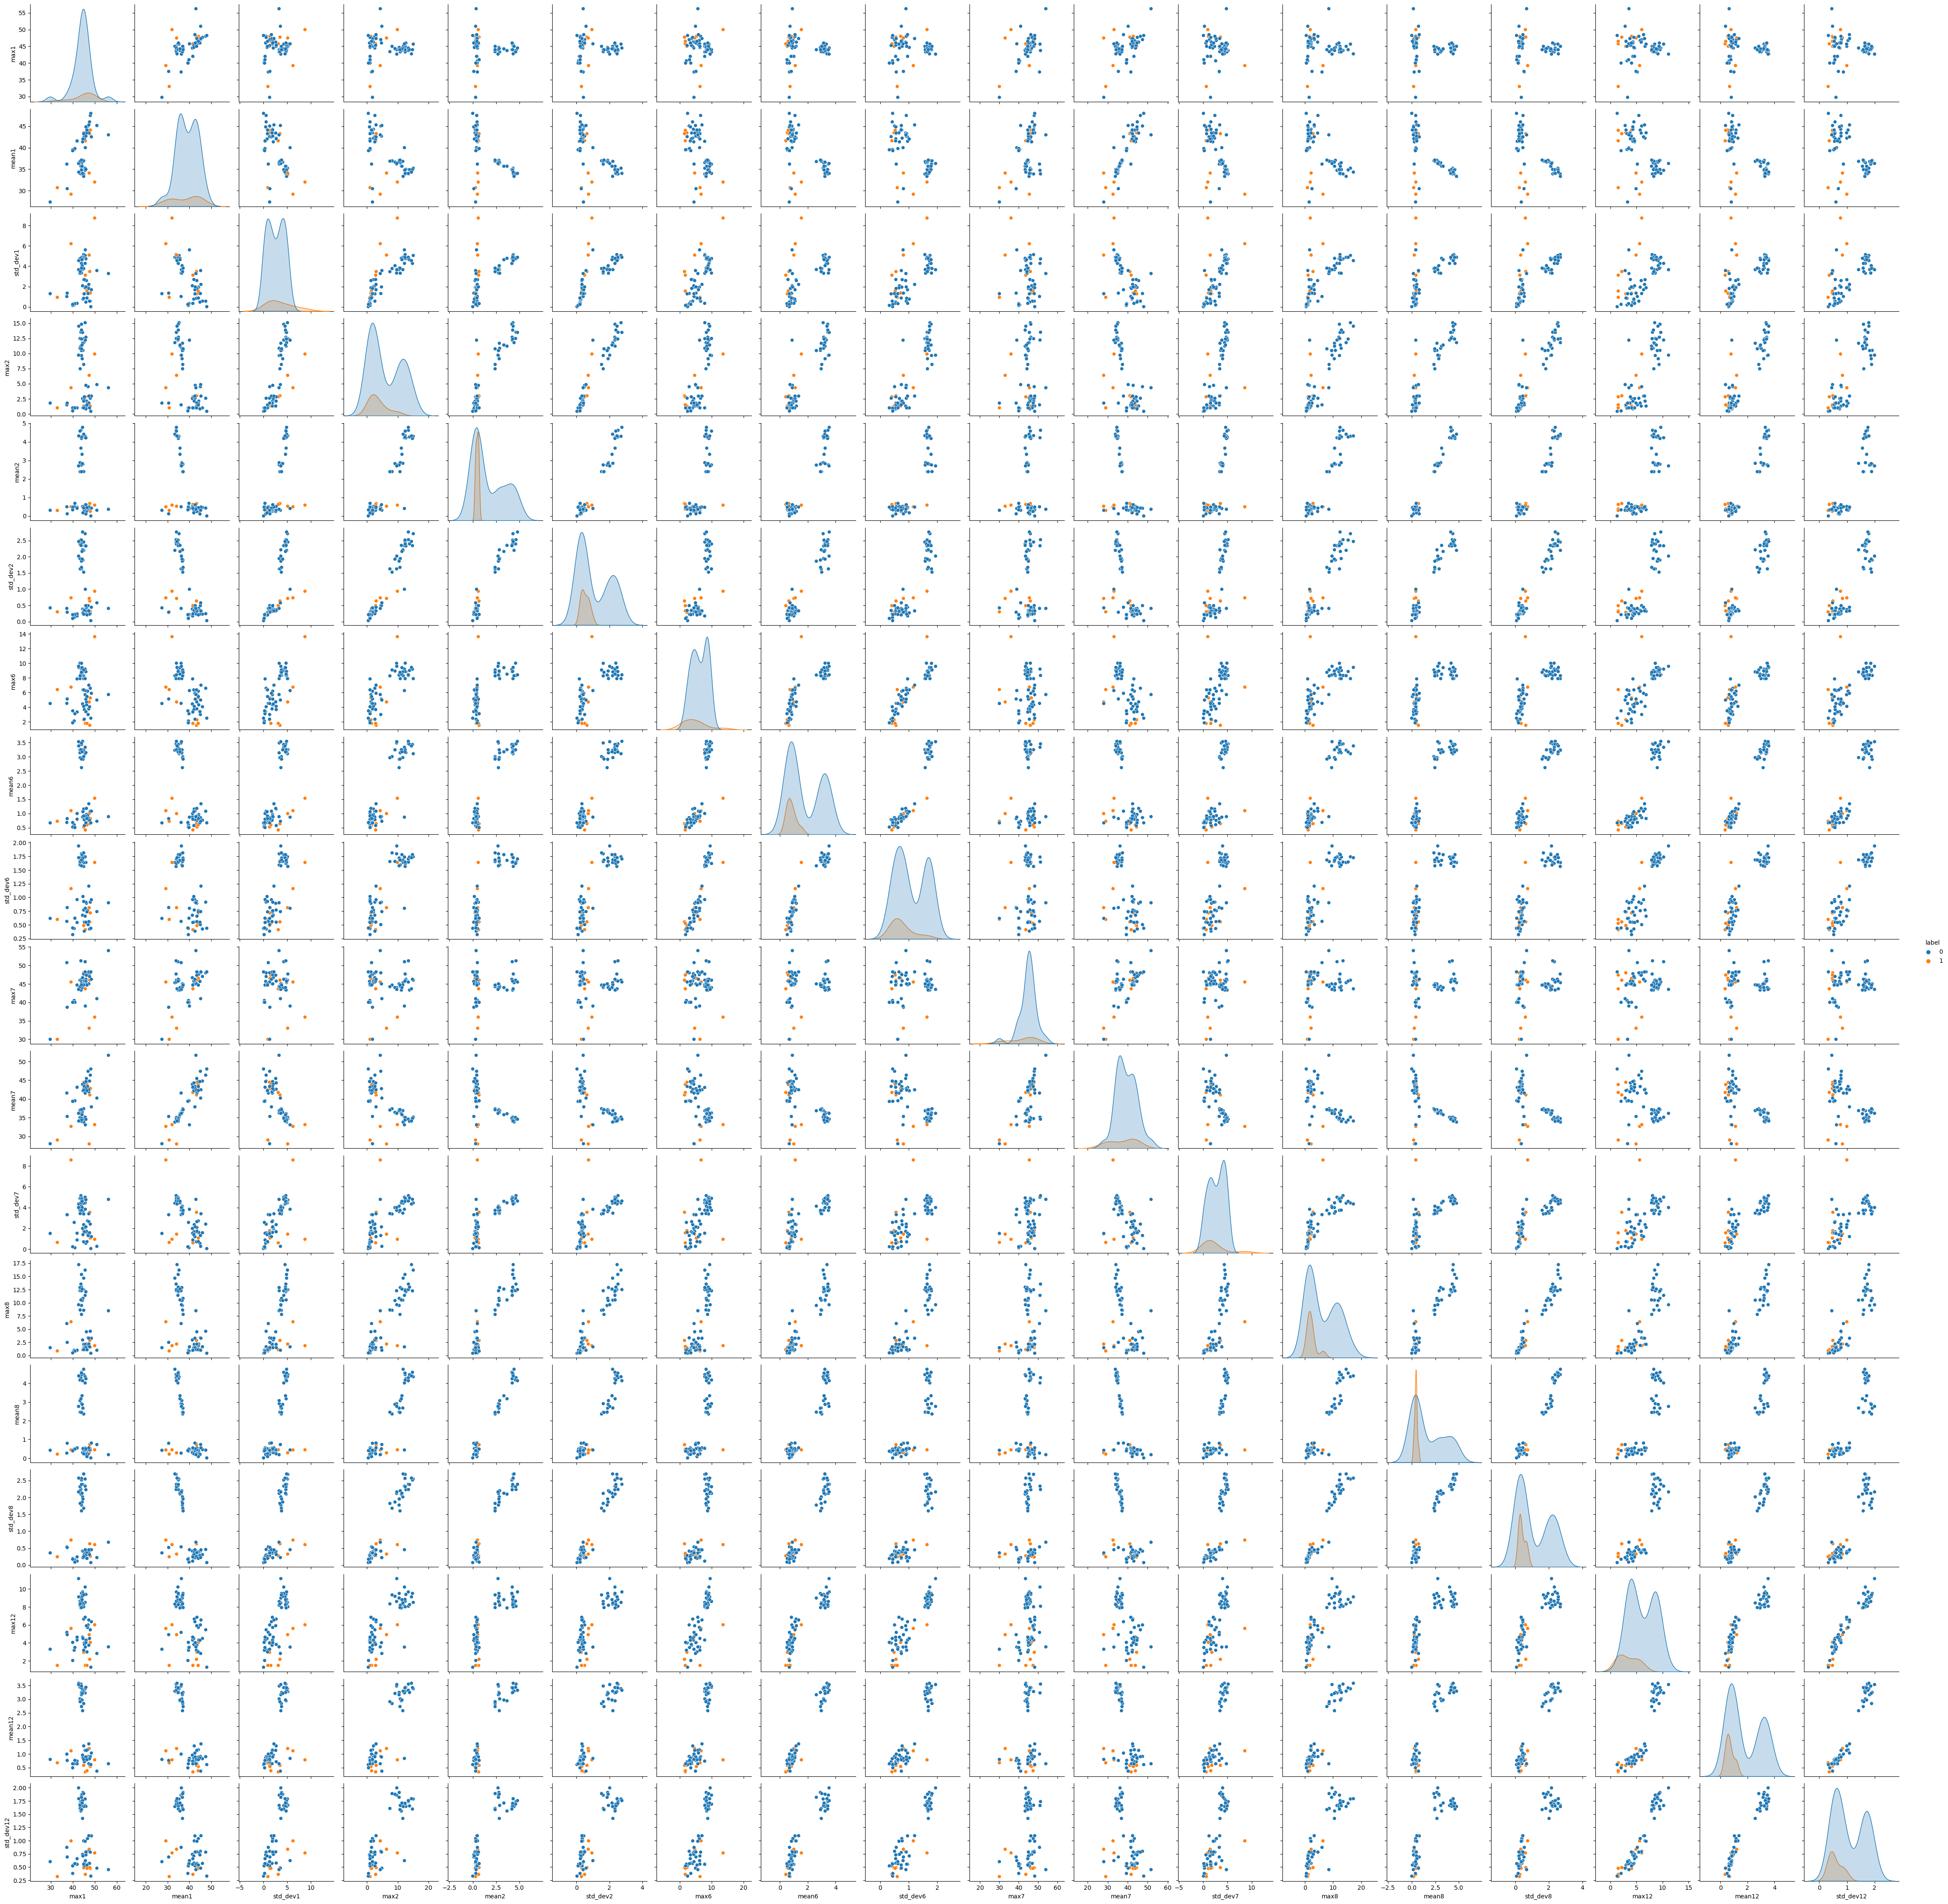

In [76]:
relevant_columns_2 = generate_col_name([1, 2, 6, 7, 8, 12], ['max', 'mean', 'std_dev'])
relevant_columns_labelled_2 = label_col_name(train_data, relevant_columns_2)
relevant_df_2 = train_data_2[relevant_columns_labelled_2]
plot_scatter_plot(relevant_df_2)  

#### Observation:
> Both of the results seem to be almost the same on first glance. There is no significant difference between the two.

#### iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression5 to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features.6 Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem.7 Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.


>Research   
> 5-fold cross-validation is a widely used technique in machine learning and model evaluation. It is a variant of k-fold cross-validation, where the dataset is divided into five equal subsets or folds. The cross-validation process is then performed as follows:  
-The dataset is randomly partitioned into five roughly equal-sized subsets or folds.  
-The model is trained and evaluated five times, where each time it is trained on four of the five subsets and tested on the remaining one. This means that each of the five folds is used as the test set exactly once.  
-5-fold cross-validation helps ensure that the model's performance estimates are more reliable and generalizable, making it a valuable tool for hyperparameter tuning and model selection. It also provides insights into the model's consistency and its ability to perform well on different subsets of the data.   
-Stratified cross-validation is a variation of k-fold cross-validation that ensures that each fold (subset) of the dataset maintains the same class distribution as the original dataset. This technique is particularly useful when dealing with imbalanced datasets, 



In [77]:
# Define a function that takes two arguments: 'stats' (a list of statistic names)
# and 'range_end' (the upper end of a range).
def generate_feature_names(stats, range_end):
    # Initialize an empty list called 'features' to store the generated feature names.
    features = []
    
    # Iterate over a range starting from 1 (inclusive) to 'range_end' (exclusive).
    for i in range(1, range_end):
        # Nested loop: Iterate over each statistic name in the 'stats' list.
        for stat in stats:
            # Construct a feature name by combining the current statistic and the loop index.
            feature_name = f'{stat}{i}'
            
            # Append the generated feature name to the 'features' list.
            features.append(feature_name)
    
    # Return the list of generated feature names.
    return features


In [78]:
# Define a function called 'oversample_data_set' that takes a 'data_set' DataFrame as input.
def oversample_data_set(data_set):
    # Print a message indicating that oversampling is being performed.
    print('Performing oversampling of dataset...')
    
    # Count the number of instances with label '0' and '1' in the dataset.
    label_0 = data_set.loc[data_set['label'] == "0"].shape[0]
    label_1 = data_set.loc[data_set['label'] == "1"].shape[0]
    
    # Determine the counts of the minority and majority classes.
    minor_count = min(label_0, label_1)
    major_count = max(label_0, label_1)
    
    # Determine the labels of the minority and majority classes.
    if label_0 > label_1:
        minor_label = "1"
        major_label = "0"
    else:
        minor_label = "0"
        major_label = "1"
    
    # Create separate DataFrames for the minority and majority classes.
    minor_ds = data_set[data_set['label'] == minor_label]
    major_ds = data_set[data_set['label'] == major_label]
    
    # Perform resampling of the minority class to match the count of the majority class.
    minor_ds = resample(minor_ds, replace=True, random_state=60, n_samples=max(label_0, label_1))
    
    # Combine the resampled minority class and the majority class into a new DataFrame.
    data_set = pd.concat([major_ds, minor_ds])
    
    # Return the oversampled dataset.
    return data_set


In [79]:
 # Define a function called 'modify_labels_to_boolean' that takes a DataFrame 'df' as input.
def modify_labels_to_boolean(df):
    # Extract the 'label' column from the DataFrame and store it in 'temp'.
    temp = df['label']
    
    # Replace the values 'bending1' and 'bending2' in the 'label' column with '1' (boolean True).
    df.loc[temp.isin(['bending1', 'bending2']), 'label'] = "1"
    
    # Replace all other values in the 'label' column with '0' (boolean False).
    df.loc[temp != "1", 'label'] = "0"
    
    # Return the modified DataFrame with boolean labels.
    return df


In [80]:
# Define a function called 'get_data_X_Y' that takes a DataFrame 'data_set' as input.
def get_data_X_Y(data_set):
    # Extract the feature columns by selecting all columns except the last one ('label').
    dataX = data_set.iloc[:, :-1]
    
    # Extract the target column ('label').
    dataY = data_set.iloc[:, -1]
    
    # Return the feature matrix 'dataX' and the target vector 'dataY'.
    return dataX, dataY


In [81]:
# Define a function called 'generate_label' that takes a 'file' as input.
def generate_label(file):
    # Extract the parent directory of the input file path.
    main_directory = os.path.dirname(file)
    
    # Split the parent directory path into components using the '/' separator.
    filename_components = main_directory.split("/")
    
    # Return the last component of the path, which represents the label.
    return filename_components[-1]



In [82]:
# Define a function called 'get_separator' that takes a 'file' as input.
def get_separator(file):
    # Open the file for reading ('f' is a file object).
    f = open(file)
    
    # Read the contents of the file and use the 'sniffer' tool to automatically detect the delimiter.
    # The 'sniffer' attempts to determine the delimiter used in the CSV file.
    detected_delimiter = sniffer.sniff(f.read()).delimiter
    
    # Return the detected delimiter.
    return detected_delimiter

# Define a function called 'generate_columns' that takes an optional argument 'segs' with a default value of 1.
def generate_columns(segs=1):
    # Calculate the total number of columns based on the number of segments ('segs').
    end = 6 * segs + 1
    
    # Create an empty list called 'feature' to store column names.
    feature = []
    
    # Use nested loops to generate column names based on statistics ('STATS') and segment indices.
    for i in range(1, end):
        for stat in STATS:
            feature.append(f'{stat}{i}')
    
    # Return the list of generated column names.
    return feature


In [83]:
# Define a function called 'load_data' that takes several parameters: 'files', 'feature', 'cols', 'segs', and 'standard'.
def load_data(files, feature, cols, segs=1, standard=False):
    # Import the 'csv' module for CSV file processing.
    import csv
    
    # Initialize empty lists to store data instances and labels.
    instances = []
    labels = []
    
    # Iterate through each file in the 'files' list.
    for f in files:
        # Extract and store the label for the current file using the 'generate_label' function.
        labels.append(generate_label(f))
        
        # Determine the separator in the CSV file using the 'get_separator' function.
        separator = get_separator(f)
        
        # Read the CSV file into a DataFrame ('fc') based on the detected separator.
        if separator == ",":
            fc = pd.read_csv(f, skiprows=5, header=None, on_bad_lines='skip')
        elif separator == "\\s+":
            fc = pd.read_csv(f, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')
        else:
            fc = pd.read_csv(f, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')
        
        # Set the column names of the DataFrame to 'ORIGINAL_COLUMN_NAMES'.
        fc.columns = ORIGINAL_COLUMN_NAMES
        
        # Break the time series data into segments of equal lengths ('seg_length').
        seg_length = int(fc.shape[0] / segs)
        description = []
        
        # Iterate through the segments and calculate statistics for each.
        for i in range(segs):
            start1 = i * seg_length
            end1 = min((i + 1) * seg_length, fc.shape[0])
            cur_seg = fc[start1 : end1]
            time_col = "# Columns: time"
            
            # Describe the current segment and drop unnecessary columns.
            cur_describe = cur_seg.describe().drop('count').drop(columns=time_col).T
            
            # Append the flattened statistics to the 'description' list.
            description.append(cur_describe.values.flatten())

        # Concatenate the descriptions of all segments to form the instance for the current file.
        instances.append(np.concatenate(description))
    
    # Create a DataFrame ('feature_df') from the instances.
    feature_df = pd.DataFrame(instances)
    
    # Set the column names of 'feature_df' based on the selected features and segments.
    feature_df.columns = generate_columns(segs)
    
    # Select the desired features from 'feature_df' based on the 'feature' parameter.
    feature_df = feature_df.loc[:, feature]
    
    # Add the 'label' column to 'feature_df'.
    feature_df['label'] = pd.Series(labels)
    
    # Return the processed DataFrame.
    return feature_df


In [84]:
# Define a function called 'logistic_regression' that takes several parameters: 'train_files', 'test_files', 'l_val', 'fold_count', 'oversample', and 'penalty'.
def logistic_regression(train_files, test_files, l_val, fold_count, oversample=False, penalty='none'):
    # Print a message indicating the current l-value.
    print(f'Running Logistic Regression for l-value {l_val}')
    
    # Generate a list of features based on 'ORDERED_Features' and 'l_val'.
    features = generate_feature_names(ORDERED_Features, 6 * l_val + 1)
    
    # Load and preprocess the training data from 'train_files' using the specified features and 'ORIGINAL_COLUMN_NAMES'.
    train_set = load_data(train_files, features, ORIGINAL_COLUMN_NAMES, segs=l_val)
    
    # Convert text labels to boolean values in the training set.
    train_set = modify_labels_to_boolean(pd.DataFrame(train_set))
    
    # Optionally, oversample the dataset to balance class distribution.
    if oversample:
        train_set = oversample_data_set(train_set)
    
    # Extract training features ('trainX') and labels ('trainY').
    trainX, trainY = get_data_X_Y(train_set)
    
    # Choose the appropriate solver based on the penalty type.
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    
    # Initialize a StratifiedKFold validator for cross-validation.
    validator = StratifiedKFold(n_splits=fold_count, shuffle=True, random_state=69)
    
    # Create a Logistic Regression model with specified penalty and solver.
    model = LogisticRegression(penalty=penalty, solver=solver, max_iter=100)
    
    # Use Recursive Feature Elimination with Cross-Validation (RFECV) for feature selection.
    selector = RFECV(estimator=model, cv=validator, scoring='accuracy')
    
    # Fit the selector on the training data to identify the best set of features.
    selector.fit(trainX, trainY)
    
    # Return the trained model and the feature selector.
    return model, selector


In [85]:
# Define the number of cross-validation folds.
cross_validation_factor = 5

# Define the maximum value of 'l_val'.
L = 20

# Create a dictionary to store combinations of 'l' and 'p' values and their corresponding scores.
combination = {
    'pair(l, p)': [],
    'score': []
}

# Loop through 'l_val' values from 1 to 'L'.
for l_val in range(1, L + 1):
    # Call the 'logistic_regression' function to train a logistic regression model with feature selection.
    model, selector = logistic_regression(train, test, l_val, cross_validation_factor, oversample=False)
    
    # Get the number of selected features.
    nf = selector.n_features_
    
    # Get the maximum mean test score from cross-validation results.
    score = selector.cv_results_['mean_test_score'].max()
    
    # Append the combination of 'l' and 'p' values along with the score to the 'combination' dictionary.
    combination['pair(l, p)'].append((l_val, nf))
    combination['score'].append(round(score, 4))

# Create a DataFrame from the 'combination' dictionary.
df = pd.DataFrame(combination)
df 

Running Logistic Regression for l-value 1
Running Logistic Regression for l-value 2
Running Logistic Regression for l-value 3
Running Logistic Regression for l-value 4
Running Logistic Regression for l-value 5
Running Logistic Regression for l-value 6
Running Logistic Regression for l-value 7
Running Logistic Regression for l-value 8
Running Logistic Regression for l-value 9
Running Logistic Regression for l-value 10
Running Logistic Regression for l-value 11
Running Logistic Regression for l-value 12
Running Logistic Regression for l-value 13
Running Logistic Regression for l-value 14
Running Logistic Regression for l-value 15
Running Logistic Regression for l-value 16
Running Logistic Regression for l-value 17
Running Logistic Regression for l-value 18
Running Logistic Regression for l-value 19
Running Logistic Regression for l-value 20


pair(l, p)   score
0      (1, 6)  1.0000
1      (2, 5)  0.9429
2      (3, 7)  0.9857
3      (4, 9)  0.9714
4      (5, 3)  0.9857
5     (6, 36)  0.9857
6     (7, 16)  0.9714
7     (8, 31)  0.9714
8     (9, 43)  0.9857
9    (10, 47)  0.9714
10    (11, 9)  0.9857
11   (12, 85)  0.9857
12   (13, 12)  0.9857
13   (14, 15)  0.9714
14   (15, 37)  0.9857
15   (16, 12)  0.9857
16   (17, 11)  0.9857
17    (18, 9)  0.9857
18   (19, 10)  0.9857
19   (20, 11)  0.9857

#### Observation:
> The correct approach is to perform Recursive Feature Elimination (RFE) in combination with Cross-Validation to estimate the error on test data. This ensures that our algorithm benefits from the full range of predictors available in our dataset. On the contrary, conducting RFE before Cross-Validation is an incorrect sequence of steps.

> Based on the scores, we can see that the highest score achieved is 1.0000, and it corresponds to the pair (1, 6). This means that when "l" is 1 and "p" is 6 (i.e., using 6 features in RFE), the model achieved a perfect score in the 5-fold cross-validation. Therefore, this pair, (1, 6), is considered the best value among the given pairs because it results in the highest performance.

#### iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

In [86]:
# Define a function named selected_features that takes two arguments: features and selector.
def get_selected_features(features, selector):
    # Create an empty list to store the selected features.
    selected_features = []
    
    # Use a for loop to iterate over the features list along with their indices.
    for i, feature in enumerate(features):
        # Check if the feature at the current index is selected by the selector.
        if selector.support_[i]:
            # If the feature is selected, add it to the selected_features list.
            selected_features.append(feature)
    
    # Return the list of selected features.
    return selected_features

In [87]:
#Extracting selected features
# Set the value of l_value to 1, 
l_value = 1

# Set the value of fold_count to 5, which seems to represent the number of folds for cross-validation.
fold_count = 5

# Call the function generate_feature_names with arguments ORDERED_Features and 6 * l_value + 1 to obtain a list of features.
features = generate_feature_names(ORDERED_Features, 6 * l_value + 1)

# Call a function, named logistic_regression, with the train and test data, l_value, and fold_count as arguments.
# This function seems to return a classifier and a feature selector.
classifier, selector = logistic_regression(train, test, l_value, fold_count)

# Call the function selected_features with the obtained features and the selector to get a list of selected features.
selected_features = get_selected_features(features, selector)

# Print or return the list of selected features. 
print("Selected features are:")
selected_features


Running Logistic Regression for l-value 1
Selected features are:


['mean1', '3rd_quartile1', 'max2', 'min5', 'max5', '1st_quartile5']

In [88]:
#P-value calculation
# Load data from the 'train' dataset using the selected features and original column names. 
# The parameter 'segs=1' is provided, indicating a segment number.
train_set = load_data(train, selected_features, ORIGINAL_COLUMN_NAMES, segs=1)

# Convert text labels in the loaded data to boolean values and store the result in a pandas DataFrame.
train_set = modify_labels_to_boolean(pd.DataFrame(train_set))

# Split the loaded data into trainX (features) and trainY (target variable).
trainX, trainY = get_data_X_Y(train_set)

# Create a DataFrame df_temp containing the features selected by selected_features.
df_temp = trainX.loc[:, selected_features]

# Add a constant term to the feature matrix for the logistic regression model.
const_val = sm.add_constant(df_temp.to_numpy(dtype=float))

# Create a logistic regression model using the logit method.
model = sm.Logit(trainY.to_numpy(dtype=float), const_val)

# Fit the logistic regression model using the 'bfgs' method and obtain a summary of the results.
summary = model.fit(method='bfgs').summary()

# Print the summary of the logistic regression model, which includes coefficients and statistics.
print(summary)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Mon, 16 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        23:25:15   Log-Likelihood:            -8.8338e-06
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7796   1.51e+07  -5.1

#### Observation:
> As per the above p-value analysis and note underneath, we can say that the data is completely seperated.
This error is generally observed with logistic regression when data is seperated and hence p-value estimates can't be reliable


In [89]:
#A utility function named plot_roc_curve that takes three arguments: actualY, predictedY_prob, and classifier.
def plot_roc_curve(actualY, predictedY_prob, classifier):
    # Create a figure and axis for plotting the ROC curves. Set the size of the figure.
    fig, axes = plt.subplots(figsize=(12, 7))
    
    # Set the title of the plot.
    axes.set_title("ROC curves")
    
    # Iterate over the classes present in the classifier.
    for i, clazz in enumerate(classifier.classes_):
        # Extract the predicted probabilities for the current class from predictedY_prob.
        y_predicted = predictedY_prob[:, i]
        
        # Compute the False Positive Rate (fpr), True Positive Rate (tpr), and thresholds for the ROC curve.
        fpr, tpr, thresholds = roc_curve(actualY, y_predicted, pos_label=clazz)
        
        # Calculate the Area Under the Curve (AUC) for the ROC curve.
        roc_auc = auc(fpr, tpr)
        
        # Plot the ROC curve, including the label with class information and ROC AUC.
        axes.plot(fpr, tpr, label=f"Class: {clazz}; ROC Curve Area: {round(roc_auc, 4)}")
    
    # Plot the diagonal dashed line representing random chance.
    axes.plot([0, 1], [0, 1], "--")
    
    # Set labels for the x and y axes.
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    
    # Display a legend with class information and ROC AUC.
    axes.legend()
    
    # Show the plot.
    plt.show()



In [90]:
# A function named cm_and_roc_calculation that takes four arguments: dataX, dataY, selected_features, and isTest.
def cm_and_roc_calculation(dataX, dataY, selected_features, isTest=False):
    # If the function is not intended for testing (isTest=False), perform the following steps:
    if not isTest:
        # Fit the classifier to the data using the selected features.
        classifier.fit(dataX.loc[:, selected_features], dataY.to_numpy(dtype="int"))
    
    # Predict the target values based on the classifier and selected features.
    predictY = classifier.predict(dataX.loc[:, selected_features])

    # Obtain predicted probabilities for each class using the classifier and selected features.
    predictY_prob = classifier.predict_proba(dataX.loc[:, selected_features])
    
    # Extract the true labels and convert them to float data type.
    y_true = dataY.to_numpy(dtype=float)
    
    # Round the predicted values to obtain binary class predictions.
    y_pred = predictY.round()
    
    # Compute the confusion matrix and print it.
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Calculate and print accuracy based on true and predicted values.
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.2%}")

    # Call the plot_roc_curve function to plot ROC curves and AUC.
    plot_roc_curve(y_true, predictY_prob, classifier)


Confusion Matrix:
[[60  0]
 [ 0  9]]
Accuracy: 100.00%


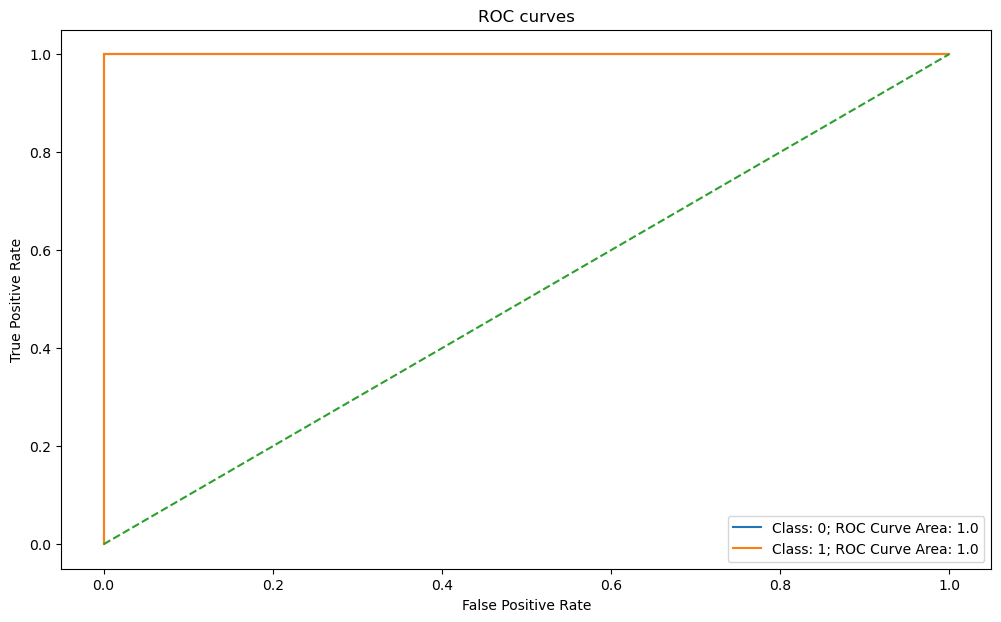

In [91]:
cm_and_roc_calculation(trainX, trainY, selected_features)

#### v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [92]:
# Load data from the 'test' dataset using the selected features and original column names.
test_set = load_data(test, selected_features, ORIGINAL_COLUMN_NAMES, segs=1)

# Convert text labels in the loaded data to boolean values and store the result in a pandas DataFrame.
test_set = modify_labels_to_boolean(pd.DataFrame(test_set))

# Split the loaded test data into testX (features) and testY (target variable).
testX, testY = get_data_X_Y(test_set)

# Display the testX data, which represents the features of the test dataset.
testX


mean1  3rd_quartile1   max2   min5   max5  1st_quartile5
0   40.624792        42.0000   1.30  27.25  38.25        33.0000
1   42.812812        43.6700   1.22  27.67  38.50        32.0000
2   34.227771        37.7500  14.50   6.75  26.00        14.7500
3   33.509729        36.7500  13.05   7.25  25.00        14.6275
4   34.660583        38.2500  13.44   7.00  24.50        14.2500
5   24.562958        26.5000   6.87  10.67  30.00        20.5000
6   27.464604        30.0000   7.76   0.00  33.00        15.0000
7   44.334729        46.5000   3.90   0.00  23.00         9.3300
8   43.174938        44.5000   2.12   2.00  21.25        12.7500
9   42.760562        45.3725   3.34   1.33  21.33        13.0000
10  42.363563        43.5000   4.44   1.00  28.00        10.1875
11  45.917667        46.5000   4.87   2.00  24.00        16.5000
12  45.239667        45.3300   1.00   4.75  26.75        17.6275
13  27.716375        29.0000   1.79   0.00  21.00         5.5000
14  44.182937        48.0000   3.11   0.00  12.75         2.0000
15  48.004167        48.0000   0.43   0.00  12.00         4.6700
16  37.177042        40.2500   8.58   7.00  25.50        17.9500
17  37.561187        40.2500   9.91  10.50  24.33        18.0000
18  37.058708        40.0625  14.17   7.50  24.25        16.0000

Confusion Matrix:
[[15  0]
 [ 0  4]]
Accuracy: 100.00%


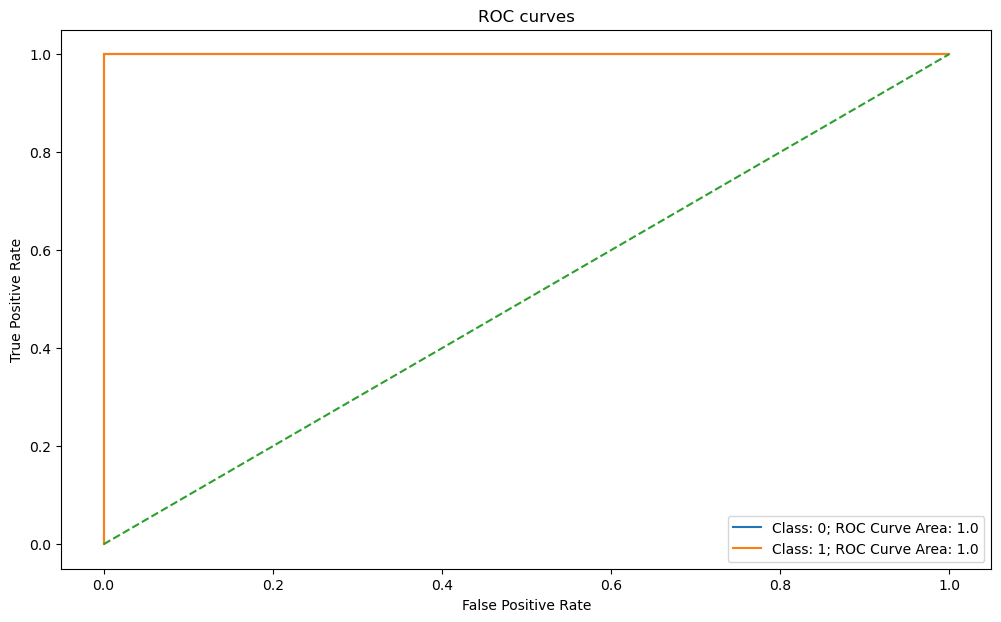

In [93]:
cm_and_roc_calculation(testX, testY, selected_features, isTest=True)

#### Observation:

>The accuracy for test as well as train cross validation seems to be almost same.

#### vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

>The p-value analysis conducted using the statmodel indicates that the data exhibits a phenomenon known as "Complete Separation." Complete Separation occurs when it is possible to perfectly predict the outcome variable (in logistic regression) using a subset of the predictor variables. In other words, there is a clear boundary or threshold in the data that completely separates the two classes.
This phenomenon creates a challenging situation for logistic regression because it leads to instability in parameter estimation. When complete separation is present, the Maximum Likelihood Estimator (MLE) becomes unreliable, and the parameters associated with the predictor variables cannot be accurately identified. In essence, the model is unable to estimate meaningful coefficients for the predictors because the data is perfectly partitioned.



#### vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

#### Observations:

> According to my assignment, 0 = non-bending classes and 1 = bending classes. I can see, according to the confusion matrices, that there are 60 instances of non-bending classes and 9 instances for bending classes which goes to show that the classes are definitely imbalanced, hence, we will build a logistic regression model based on case-control sampling.



In [94]:
# Print a message indicating that logistic regression with oversampling is being performed.
print("Performing logistic regression with oversampling=True")

# Set the number of cross-validation folds (k-fold cross-validation).
cross_validation_factor = 5

# Set the maximum value of 'l' for iteration.
L = 20

# Create an empty dictionary called 'combination' to store pairs (l, p) and corresponding scores.
combination = {
    'pair(l, p)': [],  # A list to store pairs (l, p)
    'score': []        # A list to store scores
}

# Iterate through 'l_val' from 1 to 'L' (inclusive).
for l_val in range(1, L + 1):
    # Perform logistic regression with oversampling and get the model and feature selector.
    model, selector = logistic_regression(train, test, l_val, cross_validation_factor, oversample=True)
    
    # Get the number of selected features.
    nf = selector.n_features_
    
    # Get the maximum mean test score from the feature selector's results.
    score = selector.cv_results_['mean_test_score'].max()
    
    # Append the pair (l_val, nf) to the 'pair(l, p)' list, and the score to the 'score' list in the 'combination' dictionary.
    combination['pair(l, p)'].append((l_val, nf))
    combination['score'].append(round(score, 4))

# Create a pandas DataFrame using the 'combination' dictionary.
df = pd.DataFrame(combination)

# Display the DataFrame, which contains pairs (l, p) and their corresponding scores.
df


Performing logistic regression with oversampling=True
Running Logistic Regression for l-value 1
Performing oversampling of dataset...
Running Logistic Regression for l-value 2
Performing oversampling of dataset...
Running Logistic Regression for l-value 3
Performing oversampling of dataset...
Running Logistic Regression for l-value 4
Performing oversampling of dataset...
Running Logistic Regression for l-value 5
Performing oversampling of dataset...
Running Logistic Regression for l-value 6
Performing oversampling of dataset...
Running Logistic Regression for l-value 7
Performing oversampling of dataset...
Running Logistic Regression for l-value 8
Performing oversampling of dataset...
Running Logistic Regression for l-value 9
Performing oversampling of dataset...
Running Logistic Regression for l-value 10
Performing oversampling of dataset...
Running Logistic Regression for l-value 11
Performing oversampling of dataset...
Running Logistic Regression for l-value 12
Performing oversampli

pair(l, p)   score
0      (1, 4)  1.0000
1      (2, 7)  0.9833
2      (3, 3)  1.0000
3      (4, 3)  0.9917
4      (5, 3)  0.9917
5      (6, 3)  0.9917
6      (7, 2)  0.9917
7      (8, 3)  0.9917
8      (9, 9)  1.0000
9     (10, 6)  1.0000
10    (11, 2)  0.9917
11    (12, 8)  1.0000
12    (13, 4)  1.0000
13    (14, 7)  1.0000
14    (15, 9)  1.0000
15    (16, 8)  1.0000
16    (17, 4)  1.0000
17    (18, 3)  1.0000
18    (19, 6)  1.0000
19    (20, 7)  1.0000

In [95]:
# Set the value of 'l_value' to 1.
l_value = 1

# Set the number of cross-validation folds to 5.
fold_count = 5

# Calculate the number of features based on 'l_value' and assign them to the 'features' variable.
features = generate_feature_names(ORDERED_Features, 6 * l_value + 1)

# Perform logistic regression with oversampling for the given 'l_value' and 'fold_count'.
# This step returns a classifier and a feature selector.
classifier, selector = logistic_regression(train, test, l_value, fold_count, oversample=True)

# Get the selected features using the 'selected_features' function.
selected_feature_names = get_selected_features(features, selector)

# Display the selected features.
selected_feature_names

Running Logistic Regression for l-value 1
Performing oversampling of dataset...


['3rd_quartile1', 'min5', 'max5', 'mean5']

Performing oversampling of dataset...
Confusion Matrix:
[[60  0]
 [ 0 60]]
Accuracy: 100.00%


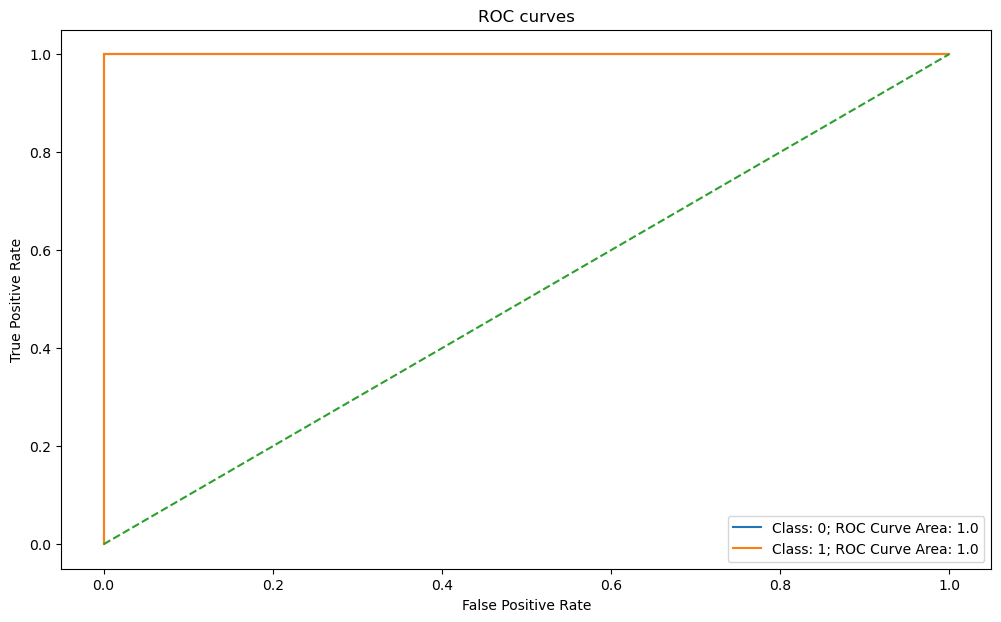

In [96]:
train_set = load_data(train, selected_features, ORIGINAL_COLUMN_NAMES, segs=1)
train_set = modify_labels_to_boolean(pd.DataFrame(train_set))
train_set = oversample_data_set(train_set)
trainX, trainY = get_data_X_Y(train_set)
cm_and_roc_calculation(trainX, trainY, selected_features)

Confusion Matrix:
[[15  0]
 [ 0  4]]
Accuracy: 100.00%


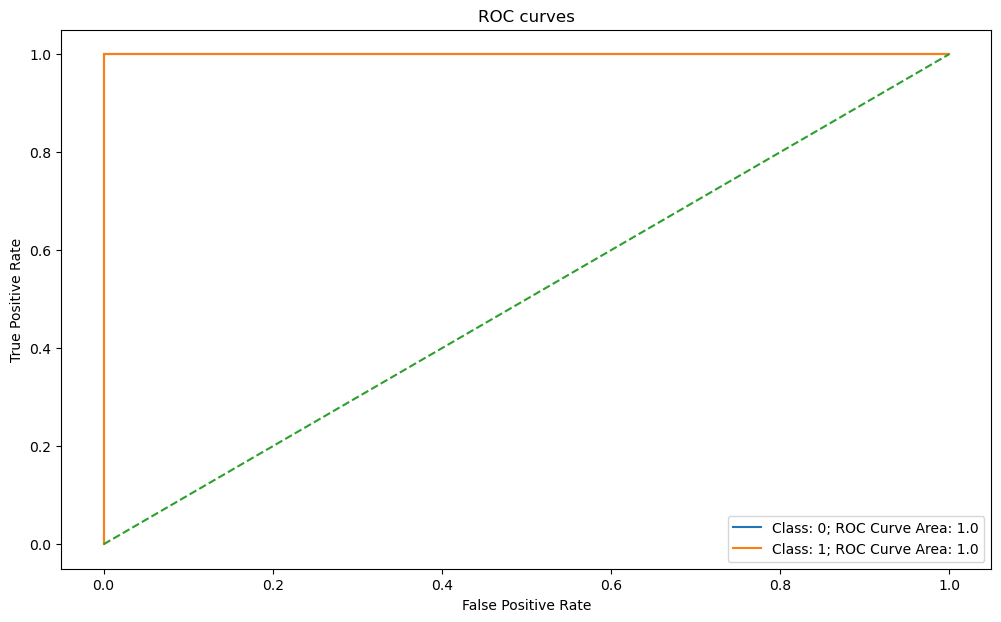

In [97]:
test_set = load_data(test, selected_features, ORIGINAL_COLUMN_NAMES, segs=1)
test_set = modify_labels_to_boolean(pd.DataFrame(test_set))
testX, testY = get_data_X_Y(test_set)
cm_and_roc_calculation(testX, testY, selected_features)

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Repeat 4(a)iii using L1-penalized logistic regression,8 i.e. instead of using p- values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you  break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.9


In [98]:
# Initialize variables to keep track of the maximum test accuracy and the corresponding L value.
max_test_accuracy = 0
optimal_L = 1

# Define a utility method for performing regression with a given classifier and other parameters.
def perform_regression_with_classifier(classifier, classifier_name, l_val, kwargs, penalty='none', 
                                      is_binary_classification=True, draw_roc=False):
    print(f'Running {classifier_name} for l-value {l_val}')
    
    # Get the features based on the specified L value.
    features = generate_feature_names(ORDERED_Features, 6 * l_val + 1)
    
    # Load the training and test data with the selected features and original column names.
    train_set = load_data(train, features, ORIGINAL_COLUMN_NAMES, segs=l_val)
    test_set = load_data(test, features, ORIGINAL_COLUMN_NAMES, segs=l_val)
    
    # If it's a binary classification task, convert the labels to binary.
    if is_binary_classification:
        train_set = get_binary_labelled_dataframe(pd.DataFrame(train_set))
        test_set = get_binary_labelled_dataframe(pd.DataFrame(test_set))
    
    # Get the data and labels for training and testing.
    trainX, trainY = get_data_X_Y(train_set)
    testX, testY = get_data_X_Y(test_set)
    
    # Ensure labels are of integer type for binary classification.
    if is_binary_classification:
        trainY = trainY.astype('int')
        testY = testY.astype('int')
    
    # Initialize a classifier with specified keyword arguments.
    classifier2 = classifier(**kwargs)
    classifier2.fit(trainX, trainY)
    
    if not draw_roc:
        # Calculate and print training and test scores.
        train_score = round(classifier2.score(trainX, trainY), 4)
        test_score = round(classifier2.score(testX, testY), 4)
        print(f'Value of L: {l_val} | train_score: {train_score} | test_score: {test_score}')
        print(f'Value of L: {l_val} | train_error: {round((1 - train_score), 4)} | test_error: {round((1 - test_score), 4)}\n')
        
        # Update maximum test accuracy and optimal L if a higher accuracy is achieved.
        global max_test_accuracy
        global optimal_L
        if test_score > max_test_accuracy:
            max_test_accuracy = test_score
            optimal_L = l_val
        
        if l_val == 20:
            # Print the maximum accuracy and set the L-value for further calculations.
            print('\n')
            print(f'The maximum accuracy is {max_test_accuracy} (for L-value: {optimal_L})')
            print(f'Further calculations will be done with L-value: {optimal_L}')
    else:
        # Calculate and print the confusion matrix for test data.
        train_predictY_prob = classifier2.predict_proba(trainX)
        test_predictY_prob = classifier2.predict_proba(testX)

        predictY = classifier2.predict(testX)
        cm = confusion_matrix(testY, predictY)
        print(f"Confusion matrix for test data:\n{cm}")
        
        # Plot ROC curves for both train and test data.
        print("ROC Curve for Train Data")
        plot_roc_curve(trainY, train_predictY_prob, classifier2)
        
        print("ROC Curve for Test Data")
        plot_roc_curve(testY, test_predictY_prob, classifier2)



In [99]:
# Define keyword arguments for the logistic regression classifier.
kwargs = {
    'penalty': 'l1',
    'max_iter': 100,
    'scoring': 'accuracy',
    'cv': 5,
    'random_state': 69,
    'solver': 'liblinear'
}

fold_count = 5

# Perform regression for each value of L from 1 to 20.
for l_val in range(1, 21):
    perform_regression_with_classifier(LogisticRegressionCV,
                                       "Logistic Regression", 
                                       l_val, 
                                       kwargs, 
                                       penalty='none',
                                       is_binary_classification=True, 
                                       draw_roc=False)

Running Logistic Regression for l-value 1
Value of L: 1 | train_score: 1.0 | test_score: 1.0
Value of L: 1 | train_error: 0.0 | test_error: 0.0

Running Logistic Regression for l-value 2
Value of L: 2 | train_score: 0.9565 | test_score: 0.9474
Value of L: 2 | train_error: 0.0435 | test_error: 0.0526

Running Logistic Regression for l-value 3
Value of L: 3 | train_score: 1.0 | test_score: 1.0
Value of L: 3 | train_error: 0.0 | test_error: 0.0

Running Logistic Regression for l-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.9474
Value of L: 4 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 5
Value of L: 5 | train_score: 1.0 | test_score: 0.9474
Value of L: 5 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 6
Value of L: 6 | train_score: 1.0 | test_score: 0.9474
Value of L: 6 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 7
Value of L: 7 | train_score: 1.0 | test_score: 1.0
Value o

Running Logistic Regression for l-value 1
Confusion matrix for test data:
[[15  0]
 [ 0  4]]
ROC Curve for Train Data


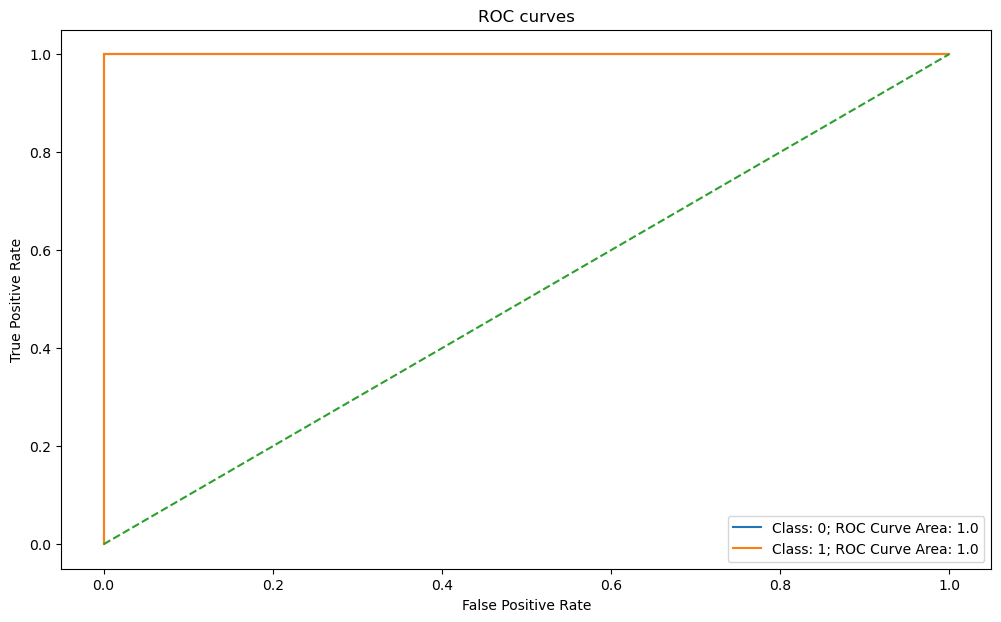

ROC Curve for Test Data


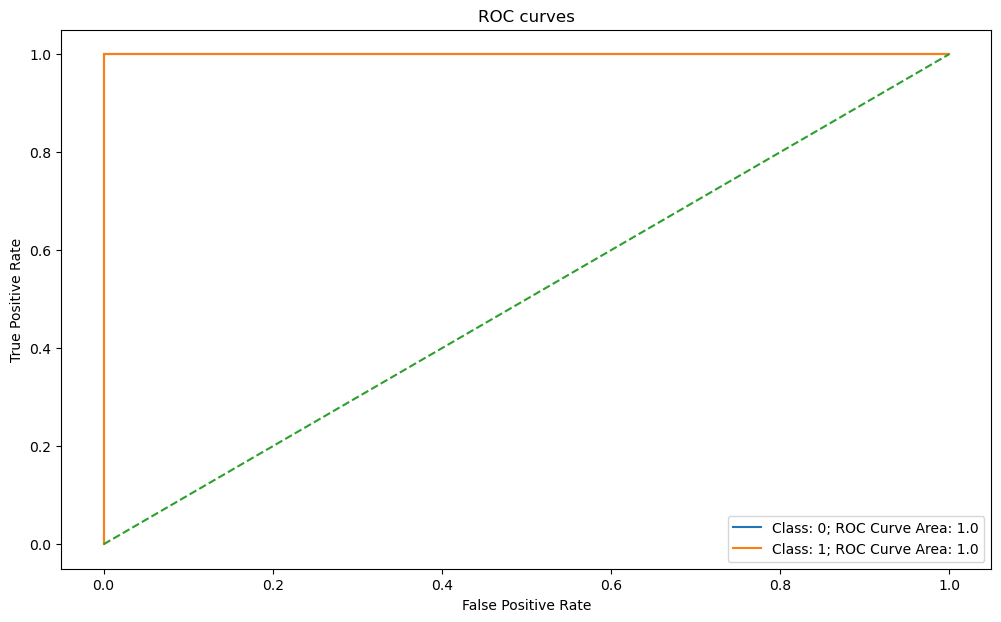

In [100]:
# Define keyword arguments (kwargs) for the logistic regression classifier.
kwargs = {
    'penalty': 'l1',  # L1 regularization penalty
    'max_iter': 100,  # Maximum number of iterations
    'solver': 'liblinear'  # Solver algorithm for optimization
}

# Define the number of folds for cross-validation (fold_count) and the best L value.
fold_count = 5  # Number of cross-validation folds
best_l = 1  # The best L value 

# Perform logistic regression with the given classifier for the best L value calculated previously.
perform_regression_with_classifier(LogisticRegression,  # The logistic regression classifier
                                   "Logistic Regression",  # A label for this classifier
                                   best_l,  # The best L value
                                   kwargs,  # The keyword arguments for the classifier
                                   penalty='none',  # No penalty (regularization)
                                   is_binary_classification=True,  # Indicates binary classification
                                   draw_roc=True)  # Draw ROC curves


#### ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?


#### Observations:

>L1-penalized logistic regression demonstrates superior performance in terms of accuracy when evaluated on the test dataset, achieving an accuracy level of approximately 1.0. As a result, L1-penalized logistic regression outperforms other methods.  L1-regularization offers practical advantages as it streamlines the feature selection process, eliminating the need for manual intervention.

### (c) Multi-class Classification (The Realistic Case)

#### i. Find the best l in the same way as you found it in 4(b)i to build an L1- penalized multinomial regression model to classify all activities in your train- ing set.10 Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.11

In [101]:
# Define keyword arguments (kwargs) for the logistic regression classifier.
kwargs = {
    'penalty': 'l1',  # L1 regularization penalty
    'max_iter': 100,  # Maximum number of iterations
    'multi_class': 'multinomial',  # Multinomial classification
    'cv': 5,  # Number of cross-validation folds
    'random_state': 69,  # Random state for reproducibility
    'solver': 'saga'  # Solver algorithm for optimization
}

fold_count = 5  # Number of cross-validation folds

global max_test_accuracy
max_test_accuracy = 0  # Initialize max_test_accuracy

global optimal_L
optimal_L = 1  # Initialize optimal_L

# Perform regression for each value of L for 20 iterations
for l_val in range(1, 21):
    perform_regression_with_classifier(LogisticRegressionCV,  # The logistic regression classifier
                                       "Logistic Regression",  # A label for this classifier
                                       l_val,  # The value of L
                                       kwargs,  # The keyword arguments for the classifier
                                       penalty='none',  # No penalty (regularization)
                                       is_binary_classification=False,  # Indicates multiclass classification
                                       draw_roc=False)  # Do not draw ROC curves


Running Logistic Regression for l-value 1
Value of L: 1 | train_score: 1.0 | test_score: 0.8947
Value of L: 1 | train_error: 0.0 | test_error: 0.1053

Running Logistic Regression for l-value 2
Value of L: 2 | train_score: 1.0 | test_score: 0.9474
Value of L: 2 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 3
Value of L: 3 | train_score: 1.0 | test_score: 0.8421
Value of L: 3 | train_error: 0.0 | test_error: 0.1579

Running Logistic Regression for l-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.8947
Value of L: 4 | train_error: 0.0 | test_error: 0.1053

Running Logistic Regression for l-value 5
Value of L: 5 | train_score: 1.0 | test_score: 0.8421
Value of L: 5 | train_error: 0.0 | test_error: 0.1579

Running Logistic Regression for l-value 6
Value of L: 6 | train_score: 1.0 | test_score: 0.7895
Value of L: 6 | train_error: 0.0 | test_error: 0.2105

Running Logistic Regression for l-value 7
Value of L: 7 | train_score: 1.0 | test_score: 0.736

Running Logistic Regression for l-value 2
Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


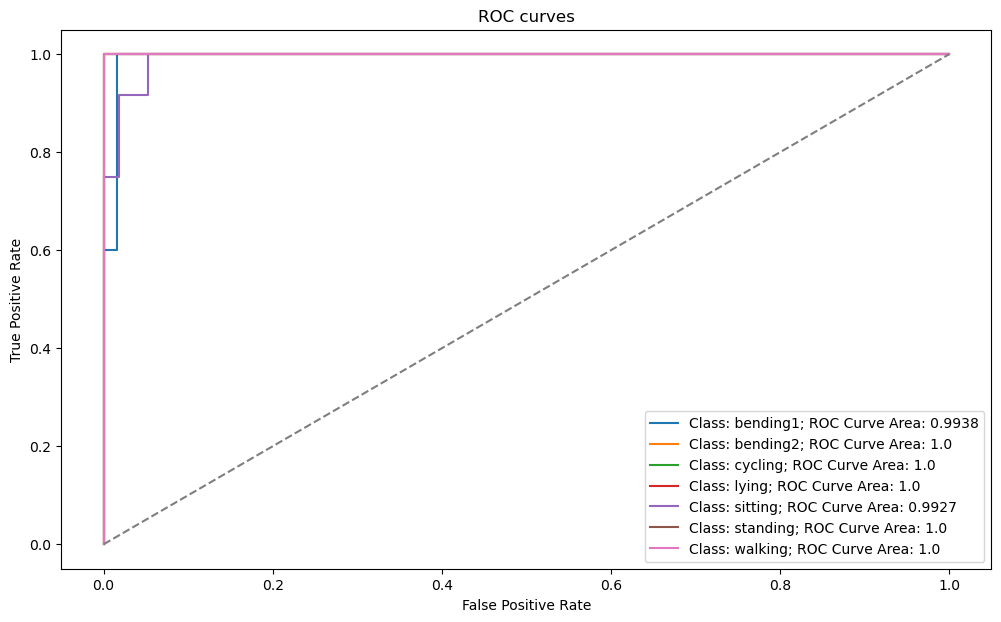

ROC Curve for Test Data


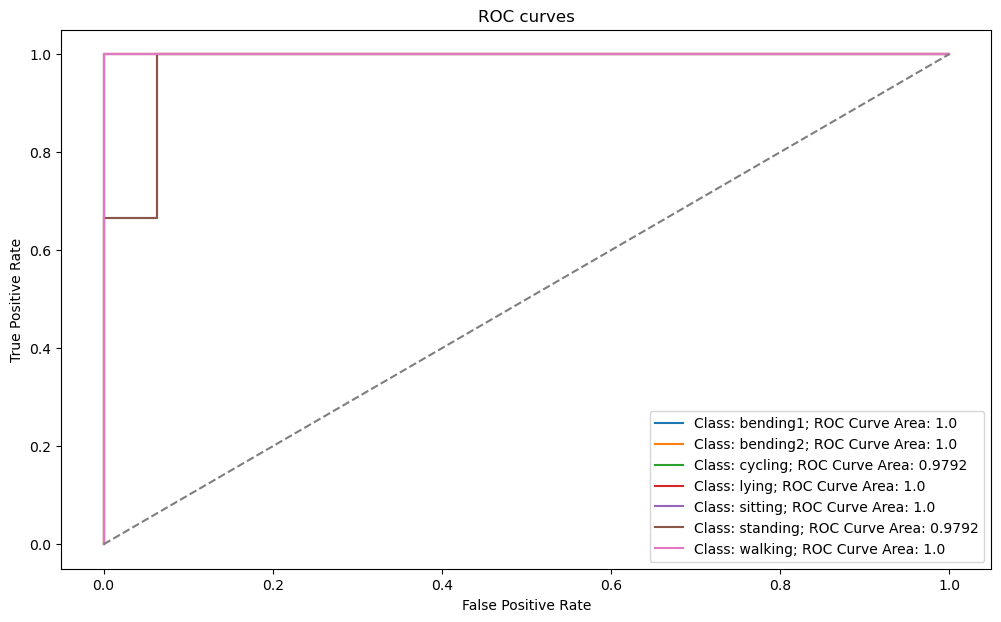

In [102]:
# Define keyword arguments (kwargs) for the logistic regression classifier.
kwargs = {
    'penalty': 'l1',  # L1 regularization penalty
    'max_iter': 100,  # Maximum number of iterations
    'multi_class': 'multinomial',  # Multinomial classification
    'solver': 'saga'  # Solver algorithm for optimization
}

fold_count = 5  # Number of cross-validation folds

best_l = optimal_L  # Use the best L value calculated earlier

# Perform regression with the given classifier for the best value of L
perform_regression_with_classifier(LogisticRegression,  # The logistic regression classifier
                                   "Logistic Regression",  # A label for this classifier
                                   best_l,  # The best value of L
                                   kwargs,  # The keyword arguments for the classifier
                                   penalty='none',  # No penalty (regularization)
                                   is_binary_classification=False,  # Indicates multiclass classification
                                   draw_roc=True)  # Draw ROC curves



#### ii. Repeat 4(c)i using a Na ̈ıve Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

In [103]:
# Define an empty dictionary for keyword arguments (kwargs). There are no specific kwargs provided.
kwargs = {}

fold_count = 5  # Number of cross-validation folds

# Initialize the maximum test accuracy and optimal L values.
global max_test_accuracy
max_test_accuracy = 0

global optimal_L
optimal_L = 1

# Loop through each value of L from 1 to 20 and perform classification for 20 iterations.
for l_val in range(1, 21):
    perform_regression_with_classifier(GaussianNB,  # Use Gaussian Naive Bayes classifier
                                       "Naive Bayes Classifier with Gaussian Prior",  # Classifier label
                                       l_val,  # Current value of L
                                       kwargs,  # Empty keyword arguments
                                       penalty='none',  # No penalty (regularization)
                                       is_binary_classification=False,  # Multiclass classification
                                       draw_roc=False)  # Do not draw ROC curves


Running Naive Bayes Classifier with Gaussian Prior for l-value 1
Value of L: 1 | train_score: 1.0 | test_score: 0.8947
Value of L: 1 | train_error: 0.0 | test_error: 0.1053

Running Naive Bayes Classifier with Gaussian Prior for l-value 2
Value of L: 2 | train_score: 1.0 | test_score: 0.6316
Value of L: 2 | train_error: 0.0 | test_error: 0.3684

Running Naive Bayes Classifier with Gaussian Prior for l-value 3
Value of L: 3 | train_score: 0.9855 | test_score: 0.7368
Value of L: 3 | train_error: 0.0145 | test_error: 0.2632

Running Naive Bayes Classifier with Gaussian Prior for l-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.7895
Value of L: 4 | train_error: 0.0 | test_error: 0.2105

Running Naive Bayes Classifier with Gaussian Prior for l-value 5
Value of L: 5 | train_score: 0.9855 | test_score: 0.7895
Value of L: 5 | train_error: 0.0145 | test_error: 0.2105

Running Naive Bayes Classifier with Gaussian Prior for l-value 6
Value of L: 6 | train_score: 0.971 | test_score: 0.63

Running Naive Bayes Classifier with Gaussian Prior for l-value 1
Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


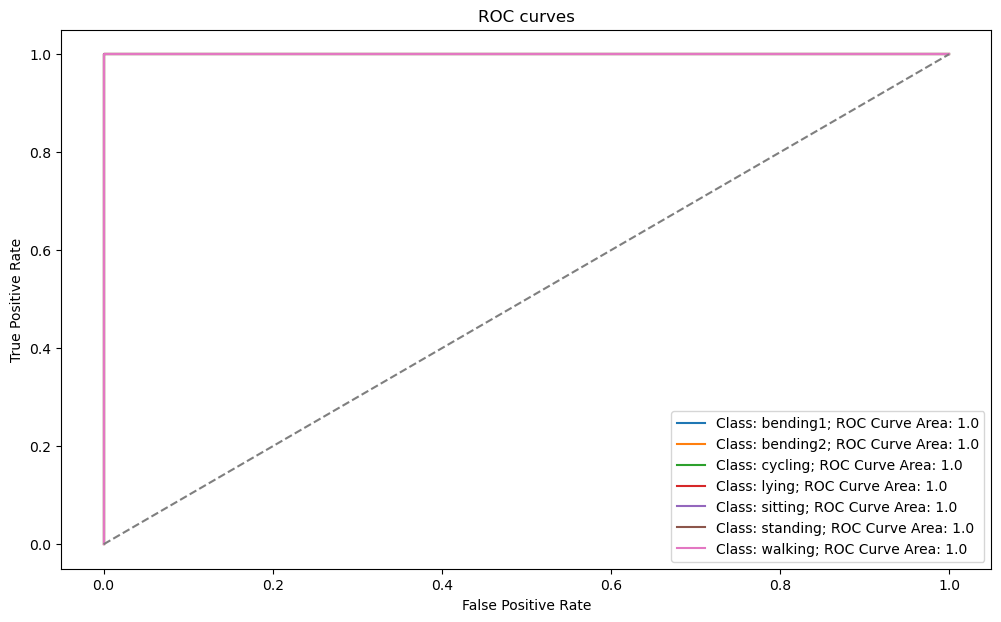

ROC Curve for Test Data


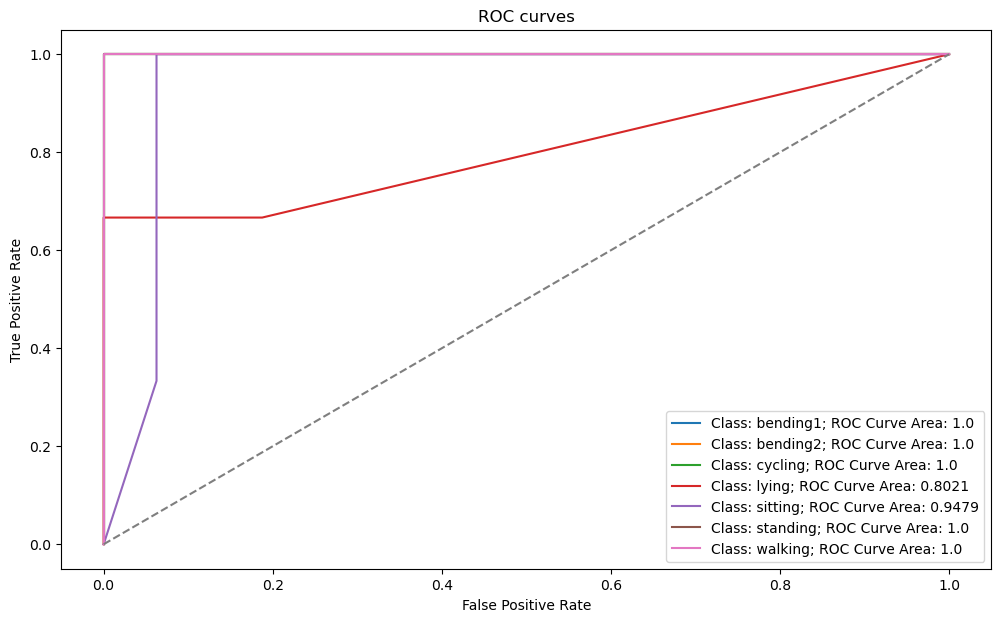

In [104]:
# Define an empty dictionary for keyword arguments (kwargs). There are no specific kwargs provided.
kwargs = {}

fold_count = 5  # Number of cross-validation folds

# Assign the best L value calculated previously to the variable best_l.
best_l = optimal_L

# Perform classification with the given classifier (Gaussian Naive Bayes) for the best value of L.
perform_regression_with_classifier(GaussianNB,  # Use Gaussian Naive Bayes classifier
                                   "Naive Bayes Classifier with Gaussian Prior",  # Classifier label
                                   best_l,  # Best value of L
                                   kwargs,  # Empty keyword arguments
                                   penalty='none',  # No penalty (regularization)
                                   is_binary_classification=False,  # Multiclass classification
                                   draw_roc=True)  # Draw ROC curves


In [105]:
# Define an empty dictionary for keyword arguments (kwargs). There are no specific kwargs provided.
kwargs = {}

fold_count = 5  # Number of cross-validation folds

# Initialize global variables for maximum test accuracy and the optimal L value.
global max_test_accuracy
global optimal_L

max_test_accuracy = 0
optimal_L = 1

# Loop over different values of L (from 1 to 20) for 20 iterations.
for l_val in range(1, 21):
    # Perform classification with the Multinomial Naive Bayes classifier for the current value of L.
    perform_regression_with_classifier(MultinomialNB,  # Use Multinomial Naive Bayes classifier
                                       "Naive Bayes Classifier with Multinomial Prior",  # Classifier label
                                       l_val,  # Current value of L
                                       kwargs,  # Empty keyword arguments
                                       penalty='none',  # No penalty (regularization)
                                       is_binary_classification=False,  # Multiclass classification
                                       draw_roc=False)  # Do not draw ROC curves


Running Naive Bayes Classifier with Multinomial Prior for l-value 1
Value of L: 1 | train_score: 0.9275 | test_score: 0.8947
Value of L: 1 | train_error: 0.0725 | test_error: 0.1053

Running Naive Bayes Classifier with Multinomial Prior for l-value 2
Value of L: 2 | train_score: 0.8841 | test_score: 0.7368
Value of L: 2 | train_error: 0.1159 | test_error: 0.2632

Running Naive Bayes Classifier with Multinomial Prior for l-value 3
Value of L: 3 | train_score: 0.8986 | test_score: 0.7895
Value of L: 3 | train_error: 0.1014 | test_error: 0.2105

Running Naive Bayes Classifier with Multinomial Prior for l-value 4
Value of L: 4 | train_score: 0.913 | test_score: 0.7895
Value of L: 4 | train_error: 0.087 | test_error: 0.2105

Running Naive Bayes Classifier with Multinomial Prior for l-value 5
Value of L: 5 | train_score: 0.9275 | test_score: 0.7368
Value of L: 5 | train_error: 0.0725 | test_error: 0.2632

Running Naive Bayes Classifier with Multinomial Prior for l-value 6
Value of L: 6 | tra

Running Naive Bayes Classifier with Multinomial Prior for l-value 1
Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


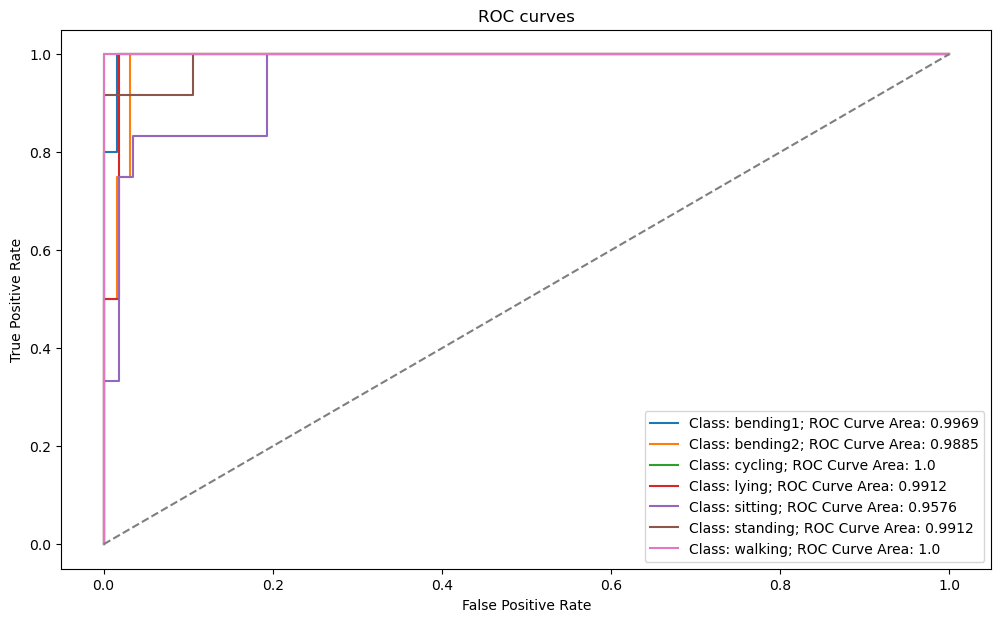

ROC Curve for Test Data


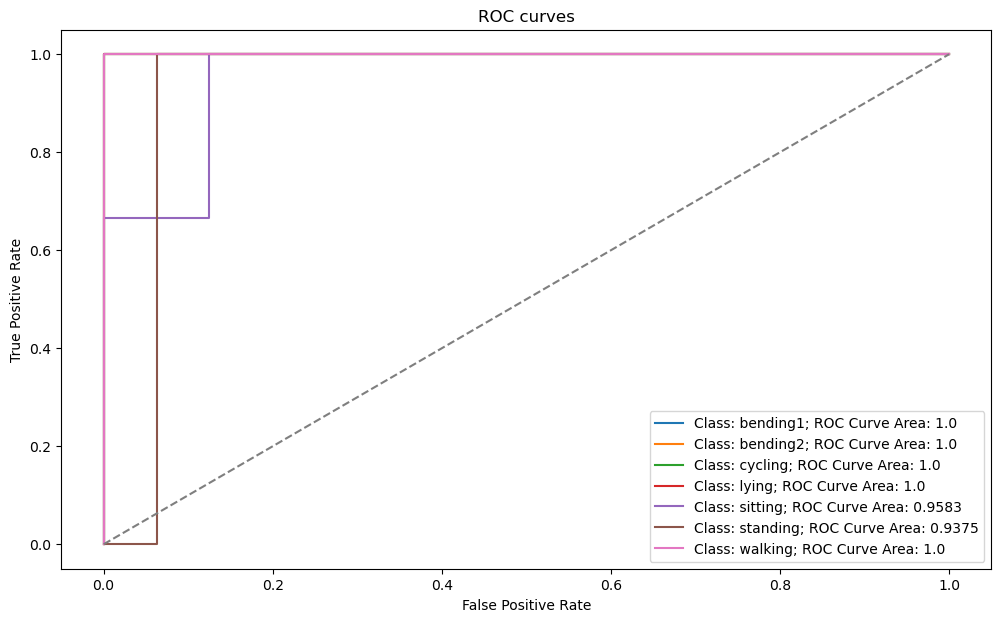

In [106]:
kwargs = {
    
}

fold_count = 5
best_l = optimal_L

# performing regression with the given classifier for the best value of L calculated from the above cell
perform_regression_with_classifier(MultinomialNB, 
                                   "Naive Bayes Classifier with Multinomial Prior",
                                   best_l, 
                                   kwargs, 
                                   penalty='none',
                                   is_binary_classification=False, 
                                   draw_roc=True)

#### iii) Which method is better for multi-class classification in this problem?

#### Observations:

> The area under the ROC curve (AUC) is relatively better for the Logistic Regression curve than any other classifer prior (Gaussian or Multinomial) and hence, Logistic Regression has better classification for the given dataset

### 3. ISLR, 4.8.3
This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a class specific mean vector and a class specific covariance matrix. We consider the simple case where p = 1; i.e. there is only one feature. Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal distribution, X ∼ N(µk, σ2 k). Recall that the density function for the one-dimensional normal distribution is given in (4.16). Prove that in this case, the Bayes classifier is not linear. Argue that it is in fact quadratic. Hint: For this problem, you should follow the arguments laid out in Section 4.4.1, but without making the assumption that σ2 1 = ... = σ2 K


We can write posterior probability of the k-th class:
$$p_k(x) = \frac {\pi_k \frac {1} {\sqrt{2 \pi} \sigma_k} \exp(- \frac {1} {2 \sigma_k^2} (x - \mu_k)^2) } {\sum { \pi_l \frac {1} {\sqrt{2 \pi} \sigma_k} \exp(- \frac {1} {2 \sigma_k^2} (x - \mu_l)^2) }}$$

The independet term w.r.t k in the above equation is:
$$C' = \frac { \frac {1} {\sqrt{2 \pi}}} {\sum { \pi_l \frac {1} {\sqrt{2 \pi} \sigma_k} \exp(- \frac {1} {2 \sigma_k^2} (x - \mu_l)^2) }}$$

Hence, 
$$p_k(x) = C' \frac{\pi_k}{\sigma_k} \exp(- \frac {1} {2 \sigma_k^2} (x - \mu_k)^2)$$
  
Taking log of both sides
$$log(p_k(x)) = log(C') + log(\pi_k) - log(\sigma_k) + (- \frac {1} {2 \sigma_k^2} (x - \mu_k)^2)$$
  
$$log(p_k(x)) = (- \frac {1} {2 \sigma_k^2} (x^2 + \mu_k^2 - 2x\mu_k)) + log(\pi_k) - log(\sigma_k) + log(C')$$
  
The first term and it is a quadratic function of x. So Bayes’s classfier not linear.

### 4. ISLR 4.8.7
 Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was X¯ = 10, while the mean for those that didn’t was X¯ = 0. In addition, the variance of X for these two sets of companies was ˆσ2 = 36. Finally, 80 % of companies issued dividends. Assuming that X follows a normal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year. Hint: Recall that the density function for a normal random variable is f(x) = √ 1 2πσ2 e−(x−µ)2/2σ2. You will need to use Bayes’ theorem.

There are two classes of response value. Here we can use Bayes’ therorem:

$$Pr(Y=Yes|X=x)=\frac{\pi_1 f_1(x)}{\sum_{l=1}^2\pi_l f_l(x)}$$

where $f_i(x) = \frac{1}{\sqrt{2\pi\sigma_i^2}}e^{\frac{-1}{2\sigma_i^2}(x - \mu_i)^2}$ 

Here $\pi_1 = 0.8, \pi_2 = 0.2$, $f_1(x)$ is the density function of a normal random variable with mean $10$ and variance $36$ and $f_2(x)$ is the density function of a normal random variable with mean $0$ and variance $36$.

Pluggin all values to the above equation: 

$$Pr(Y=Yes|X=x) = \frac{0.8e^{\frac{-1}{2*36}(4 - 10)^2}}{0.8e^{\frac{-1}{2*36}(4 - 10)^2} + 0.2e^{\frac{-1}{2*36}(4 - 0)^2}}$$

$$Pr(Y=Yes|X=x) = 0.7519$$


References:
>- https://stackoverflow.com/questions/45346550/valueerror-unknown-label-type-unknown
> - https://www.statsmodels.org/stable/index.html
> - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
> - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
>- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
> - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html